In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json
from LabelAlis import LabelAlis
from scipy.stats import spearmanr

Coverage_Of_PfamChoppedStruct = 0
Coverage_Of_PfamOnQueryPosThresh = 0.25
FalsePositiveThreshold = 0.25

In [2]:
def difference(df1, df2):
    """This is for finding the rows in df1 and not in df2"""
    merged_df = pd.merge(df1, df2, indicator=True, how='outer')
    return merged_df[merged_df['_merge'] == 'left_only'].drop('_merge', axis=1)

In [3]:
def SplitTargetSeedInfo(PdSeries):
    AlnPfDf = PdSeries.str.split("_", expand=True)
    AlnPfDf.columns = ["targetprot", "targetprotstart","targetprotend","predpf"]
    AlnPfDf["targetprotstart"] = AlnPfDf["targetprotstart"].astype(int)
    AlnPfDf["targetprotend"] = AlnPfDf["targetprotend"].astype(int)
    return AlnPfDf

In [4]:
def ExpandSeedAnns(AlnPfDf, pfClans):
    AlnPfDf = pd.concat([AlnPfDf, SplitTargetSeedInfo(AlnPfDf['target']) ], axis=1) 
    return AlnPfDf

In [5]:
def Labeler(inputfile, clanassociation, pf, instance_database, cols2merge = ["qstart", "qend"], bitscutoff=None ): #probcolname = "None",
    df= pd.read_csv(inputfile, sep="\t")
    if bitscutoff!= None:
        df = df[df["bits"]>=bitscutoff]
    #df = df[df["bits"]>=152]
#    if (probcolname != "None"):
#        df=df[df[probcolname]>=0.5]
    if instance_database:
        df = ExpandSeedAnns(df, clanassociation)
    processed_df = df.merge(clanassociation, left_on = "predpf", right_on = "pf",how="left").drop("pf", axis=1).rename(columns={"clan":"predclan"})
    Labeled_my= LabelAlis(processed_df, pf, clanassociation, ["qstart", "qend"], how2merge="right")
    prefix = pf.columns[1]
    Labeled_my = Labeled_my[(Labeled_my["isseed"]!=1 )] #|(Labeled_my["equalto"+ prefix + "preds"]==-1 )] ####NOTE: I am discarding Seed annotations for this plot
    label = pf.columns[1]
    label_dict = {0: "FP", 1: "TP", -1: "FN"}
    Labeled_my['labelcol_str']= Labeled_my["equalto{}preds".format(label)].map(label_dict)
    #Labeled_my = Labeled_my[Labeled_my["bits"]>=152]
    return Labeled_my

In [6]:
def OneHotEncodingLabel(df):
    df['is_TP'] = (df['labelcol_str'] == 'TP').astype(int)
    df['is_FP'] = (df['labelcol_str'] == 'FP').astype(int)
    df['is_FN'] = (df['labelcol_str'] == 'FN').astype(int)
    return df

In [7]:
clanassociation = pd.read_csv("../PfamClanAssociation.tsv",header=None, names = ["pf", "clan"], sep="\t" )

In [58]:
def PrecisionRecall(df, col):
    TPs = df[df[col]==1 ].shape[0]
    FPs = df[df[col]==0 ].shape[0]
    FNs = df[df[col]==-1].shape[0]
    #totalPreds = pfdf[pfdf["isseed"] !=1 ].shape[0]
    #FNs = totalPreds - TPs - FPs
    Precision = TPs/(TPs + FPs)
    Recall = TPs/(TPs + FNs + FPs)
    return Precision, Recall

In [57]:
def PlotDistributionOfLablesForAColumns(AlnDF,col4dist, label4plot, log_scale=False, legen2loc = "upper left"):
#    label_dict = {0: "FP", 1: "TP", -1: "FN"}
#    xlab_dict = {""}
# Create a new column 'labelcol_str' in the DataFrame
#    AlnDF['labelcol_str'] = AlnDF[labelcol].map(label_dict)
    plt.figure(figsize=(10, 6), dpi=150)
    ax1 = sns.kdeplot(data=AlnDF, x=col4dist, hue='labelcol_str', log_scale=log_scale,shade=True,palette='colorblind')
    
    legend = ax1.legend_
    legend.set_title(None)
    for text in legend.get_texts():
        text.set_fontsize(15)
    ax1.set_xlabel(label4plot, fontsize=15)
    ax1.set_ylabel("Density", fontsize=15)
    ax1.tick_params(axis='both', which='major', labelsize=15)
  

# Calculating rolling Precision and Recall
    
    window_size = 200  # Change this value as needed

# Sort the DataFrame by length
    AlnDF2 = AlnDF.sort_values(by=col4dist)

# Calculate the rolling sums of TP, FP and FN
    AlnDF2['TP_sum'] = AlnDF2['is_TP'].rolling(window=window_size, center=True).sum() #
    AlnDF2['FP_sum'] = AlnDF2['is_FP'].rolling(window=window_size, center=True).sum() #
    AlnDF2['FN_sum'] = AlnDF2['is_FN'].rolling(window=window_size, center=True).sum() #
    
    AlnDF2['Precision'] = AlnDF2['TP_sum'] / (AlnDF2['TP_sum'] + AlnDF2['FP_sum'])
    AlnDF2['Recall'] = AlnDF2['TP_sum'] / (AlnDF2['TP_sum'] + AlnDF2['FN_sum'] + AlnDF2['FP_sum'])
    
    ax2 = ax1.twinx()
    ax2.plot(AlnDF2[col4dist], AlnDF2['Precision'], color='red', label='Precision',linewidth=1)  # Modify as needed
    if AlnDF2['is_FN'].sum()!=0:
        ax2.plot(AlnDF2[col4dist], AlnDF2['Recall'], color='blue', label='Recall',linewidth=1)  # Modify as needed
        ax2.set_ylabel('Precision/Recall', fontsize=15)
    else:
        ax2.set_ylabel('Precision', fontsize=15)
    ax2.legend(loc=legen2loc, fontsize=15)
    ax2.tick_params(axis='y', which='major', labelsize=15)
    ax2.set_ylim(0,1.05)
    #From now on it is for calculating the binned precision and recall

# Pfam as the Gold Standard

In [56]:
pf = pd.read_csv("../PfamTb_SeedMeanlddtSize.txt",sep="\t")
FS_preds_vsPF = OneHotEncodingLabel(Labeler("../aln_Tb_pf_gr_fmt.tsv", clanassociation, pf, instance_database = True, bitscutoff=152)) #
FS_preds_vsPF_nobits = OneHotEncodingLabel(Labeler("../aln_Tb_pf_gr_fmt.tsv", clanassociation, pf, instance_database = True))
MM_preds_vsPF = OneHotEncodingLabel(Labeler("../aln_Tb_pf_gr_seq_fmt.tsv", clanassociation, pf, instance_database = True))

In [11]:
FS_preds_vsPF['is_TP'].sum()

3523

In [13]:
FS_preds_vsPF_nobits['is_TP'].sum()

3569

In [12]:
FS_preds_vsPF['is_FP'].sum()

589

In [15]:
FS_preds_vsPF_nobits['is_FP'].sum()

719

In [16]:
FS_preds_vsPF['is_FN'].sum()

1291

In [17]:
FS_preds_vsPF_nobits['is_FN'].sum()

1115

In [13]:
FS_preds_vsPF[FS_preds_vsPF["equaltopfampreds"]==0].shape

(589, 37)

In [14]:
HMMER_preds_vsPF = OneHotEncodingLabel(Labeler("../HmmerGreedyHits.tsv", clanassociation, pf, instance_database = False ))

In [15]:
ToolVSBenchmark = {"FS_preds_vsPF": FS_preds_vsPF,"MM_preds_vsPF":MM_preds_vsPF, "HMMER_preds_vsPF": HMMER_preds_vsPF }

In [20]:
prefix = "pfam"

In [21]:
FS_preds_vsPF.columns

Index(['query', 'target', 'fident', 'alnlen', 'mismatch', 'gapopen', 'qstart',
       'qend', 'tstart', 'tend', 'qlen', 'tlen', 'evalue', 'bits',
       'alntmscore', 'lddt', 'prob', 'tcov', 'targetprot', 'targetprotstart',
       'targetprotend', 'predpf', 'predclan', 'pfam', 'pfstart', 'pfend',
       'isseed', 'meanlddt', 'size', 'pfamcov', 'pfamclan', 'equaltopfampreds',
       'pfamclanisidentical', 'labelcol_str', 'is_TP', 'is_FP', 'is_FN'],
      dtype='object')

In [16]:
FS_preds_vsPF[FS_preds_vsPF["equaltopfampreds"]==1].shape[0]

3523

In [17]:
for key, value in ToolVSBenchmark.items():
    print(key)
    print(value.shape[0])

FS_preds_vsPF
5403
MM_preds_vsPF
5403
HMMER_preds_vsPF
5403


In [91]:
FS_preds_PF_ov_precision_pf_level,FS_preds_PF_ov_recall_pf_level = PrecisionRecall(FS_preds_vsPF, "equaltopfampreds")
print("The followings are for Pfam-level Foldseek annotation when Pfam is considered as the Gold Standard")
print("Precision is {} ".format(FS_preds_PF_ov_precision_pf_level))
print("Recall is {} ".format(FS_preds_PF_ov_recall_pf_level))

The followings are for Pfam-level Foldseek annotation when Pfam is considered as the Gold Standard
Precision is 0.856760700389105 
Recall is 0.6520451600962428 


In [93]:
FS_preds_PF_ov_precision_pf_level_nb,FS_preds_PF_ov_recall_pf_level_nb = PrecisionRecall(FS_preds_vsPF_nobits, "equaltopfampreds")
print("The followings are for Pfam-level Foldseek annotation when Pfam is considered as the Gold Standard")
print("Precision is {} ".format(FS_preds_PF_ov_precision_pf_level_nb))
print("Recall is {} ".format(FS_preds_PF_ov_recall_pf_level_nb))

The followings are for Pfam-level Foldseek annotation when Pfam is considered as the Gold Standard
Precision is 0.8323227611940298 
Recall is 0.6605589487321858 


In [94]:
print(FS_preds_PF_ov_precision_pf_level_nb - FS_preds_PF_ov_precision_pf_level)
print(FS_preds_PF_ov_recall_pf_level_nb - FS_preds_PF_ov_recall_pf_level)

-0.024437939195075198
0.008513788635942987


In [47]:
print(FS_preds_vsPF[FS_preds_vsPF["equaltopfampreds"]==1].shape[0])

3569


In [23]:
FS_preds_PF_ov_precision_clan_level,FS_preds_PF_ov_recall_clan_level = PrecisionRecall(FS_preds_vsPF, "pfamclanisidentical")
print("The followings are for Clan-level Foldseek annotation when Pfam is considered as the Gold Standard")
print("Precision is {} ".format(FS_preds_PF_ov_precision_clan_level))
print("Recall is {} ".format(FS_preds_PF_ov_recall_clan_level))

The followings are for Clan-level Foldseek annotation when Pfam is considered as the Gold Standard
Precision is 0.9834630350194552 
Recall is 0.7484730705163798 


Let's see the difference in the size of domains predicted by Foldseek and those predicted by Pfam v35.

(-100.0, 1000.0)

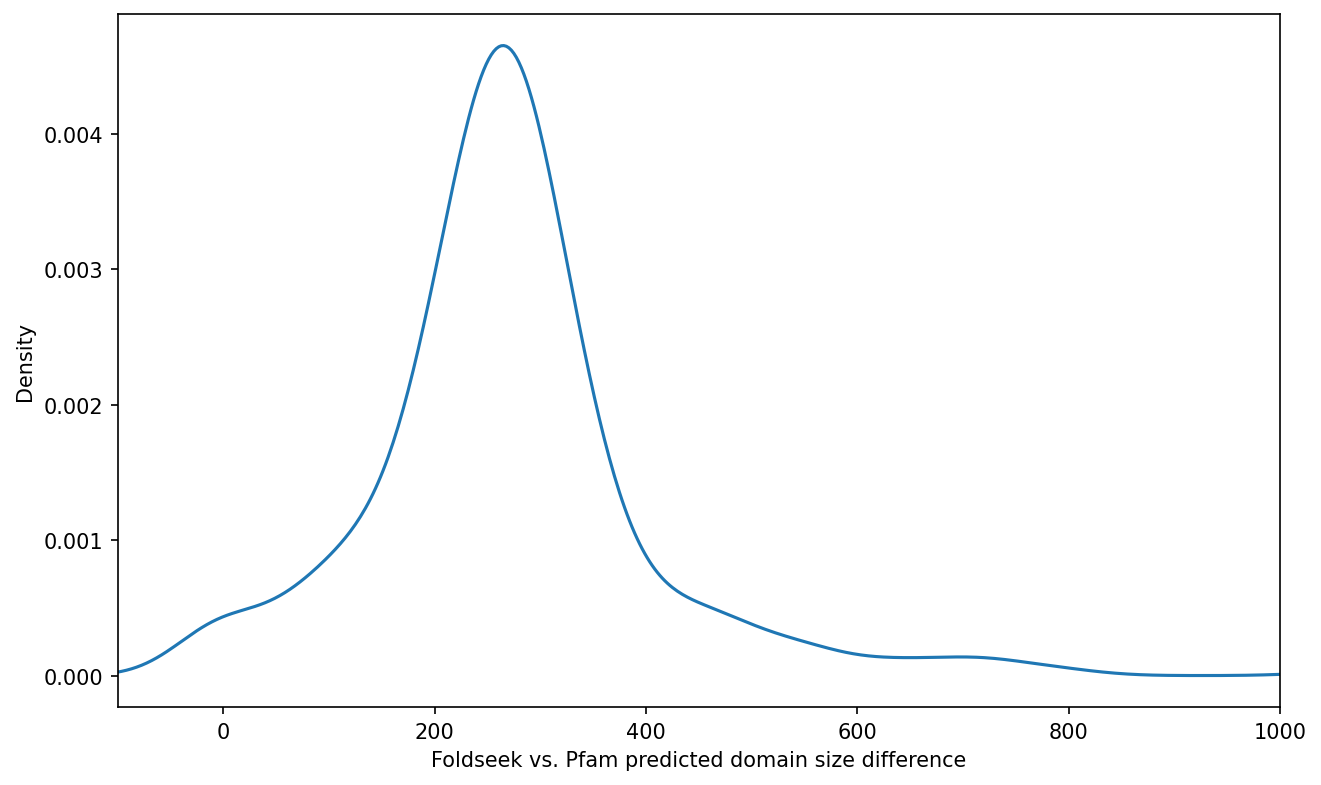

In [24]:
FPs_PF = FS_preds_vsPF[FS_preds_vsPF["labelcol_str"]=="FP"]
FPs_PF=FPs_PF[(FPs_PF["qend"] - FPs_PF["qstart"]+1)>=200]
plt.figure(figsize=(10, 6), dpi=150)
((FPs_PF["qend"] - FPs_PF["qstart"]) - (FPs_PF["pfend"] - FPs_PF["pfstart"])).plot.kde()
plt.xlabel("Foldseek vs. Pfam predicted domain size difference")
plt.xlim((-100,1000))

In [26]:
MM_preds_PF_ov_precision_PF_level,MM_preds_PF_ov_recall_PF_level = PrecisionRecall(MM_preds_vsPF, "equaltopfampreds")
print("The followings are for Pfam-level MMseqs2 annotation when Pfam is considered as the Gold Standard")
print("Precision is {} ".format(MM_preds_PF_ov_precision_PF_level))
print("Recall is {} ".format(MM_preds_PF_ov_recall_PF_level))

The followings are for Pfam-level MMseqs2 annotation when Pfam is considered as the Gold Standard
Precision is 0.9646171693735499 
Recall is 0.6155839348510087 


In [27]:
MM_preds_PF_ov_precision_clan_level,MM_preds_PF_ov_recall_clan_level = PrecisionRecall(MM_preds_vsPF, "pfamclanisidentical")
print("The followings are for Clan-level MMseqs2 annotation when Pfam is considered as the Gold Standard")
print("Precision is {} ".format(MM_preds_PF_ov_precision_clan_level))
print("Recall is {} ".format(MM_preds_PF_ov_recall_clan_level))

The followings are for Clan-level MMseqs2 annotation when Pfam is considered as the Gold Standard
Precision is 0.9933294663573086 
Recall is 0.6339070886544512 


In [30]:
HMMER_preds_PF_ov_precision_PF_level,HMMER_preds_PF_ov_recall_PF_level = PrecisionRecall(HMMER_preds_vsPF, "equaltopfampreds")
print("The followings are for Pfam-level HMMER annotation when Pfam is considered as the Gold Standard")
print("Precision is {} ".format(HMMER_preds_PF_ov_precision_PF_level))
print("Recall is {} ".format(HMMER_preds_PF_ov_recall_PF_level))

The followings are for Pfam-level HMMER annotation when Pfam is considered as the Gold Standard
Precision is 0.938732928679818 
Recall is 0.9159726078104756 


In [31]:
HMMER_preds_PF_ov_precision_clan_level,HMMER_preds_PF_ov_recall_clan_level = PrecisionRecall(HMMER_preds_vsPF, "pfamclanisidentical")
print("The followings are for Clan-level HMMER annotation when Pfam is considered as the Gold Standard")
print("Precision is {} ".format(HMMER_preds_PF_ov_precision_clan_level))
print("Recall is {} ".format(HMMER_preds_PF_ov_recall_clan_level))

The followings are for Clan-level HMMER annotation when Pfam is considered as the Gold Standard
Precision is 0.9884294385432474 
Recall is 0.9644641865630206 


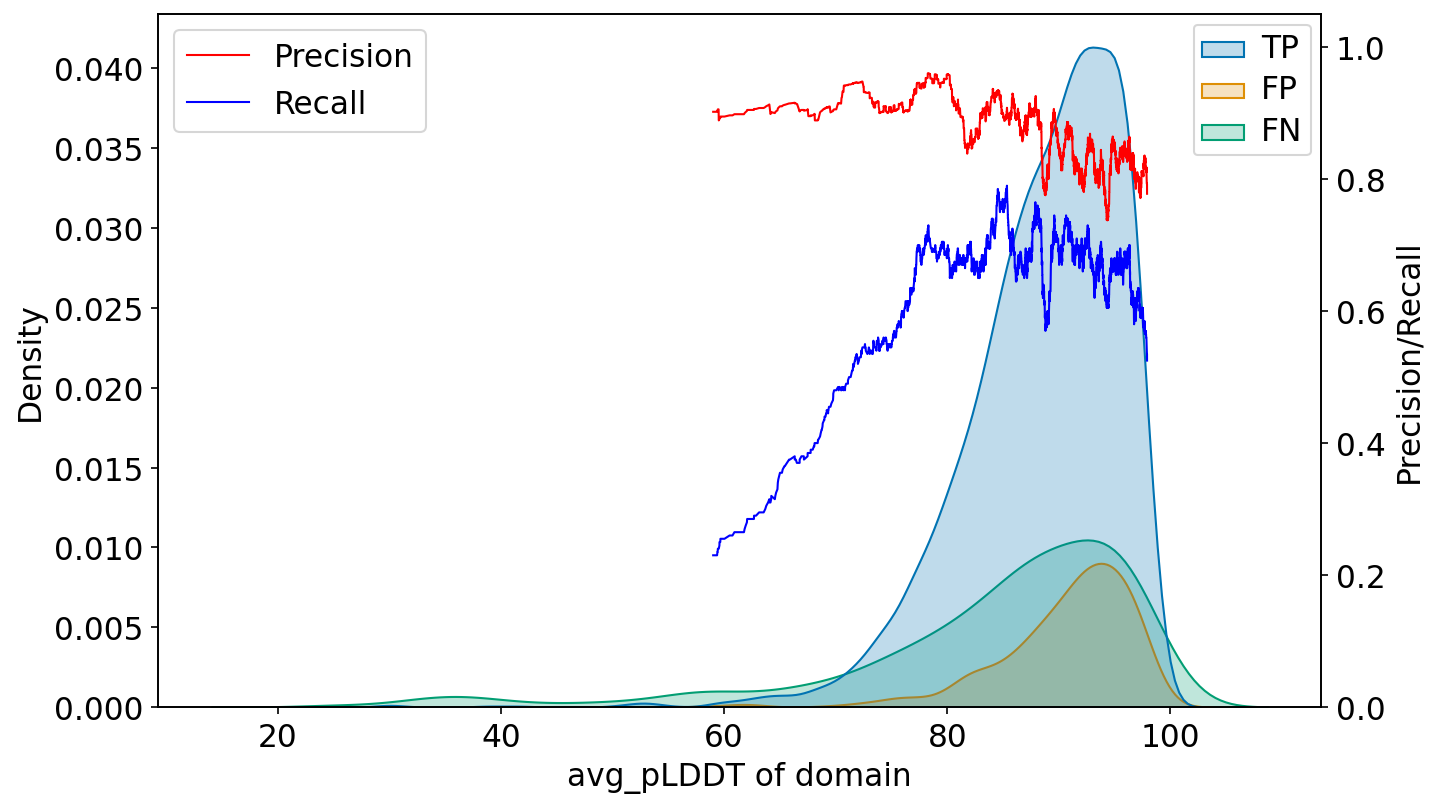

In [50]:
PlotDistributionOfLablesForAColumns(FS_preds_vsPF, "meanlddt", "avg_pLDDT of domain")

In [51]:
print(FS_preds_vsPF[FS_preds_vsPF["meanlddt"]<=70]['size'].mean())
print(FS_preds_vsPF[FS_preds_vsPF["meanlddt"]>=80]['size'].mean())

127.77375565610859
155.38397077782554


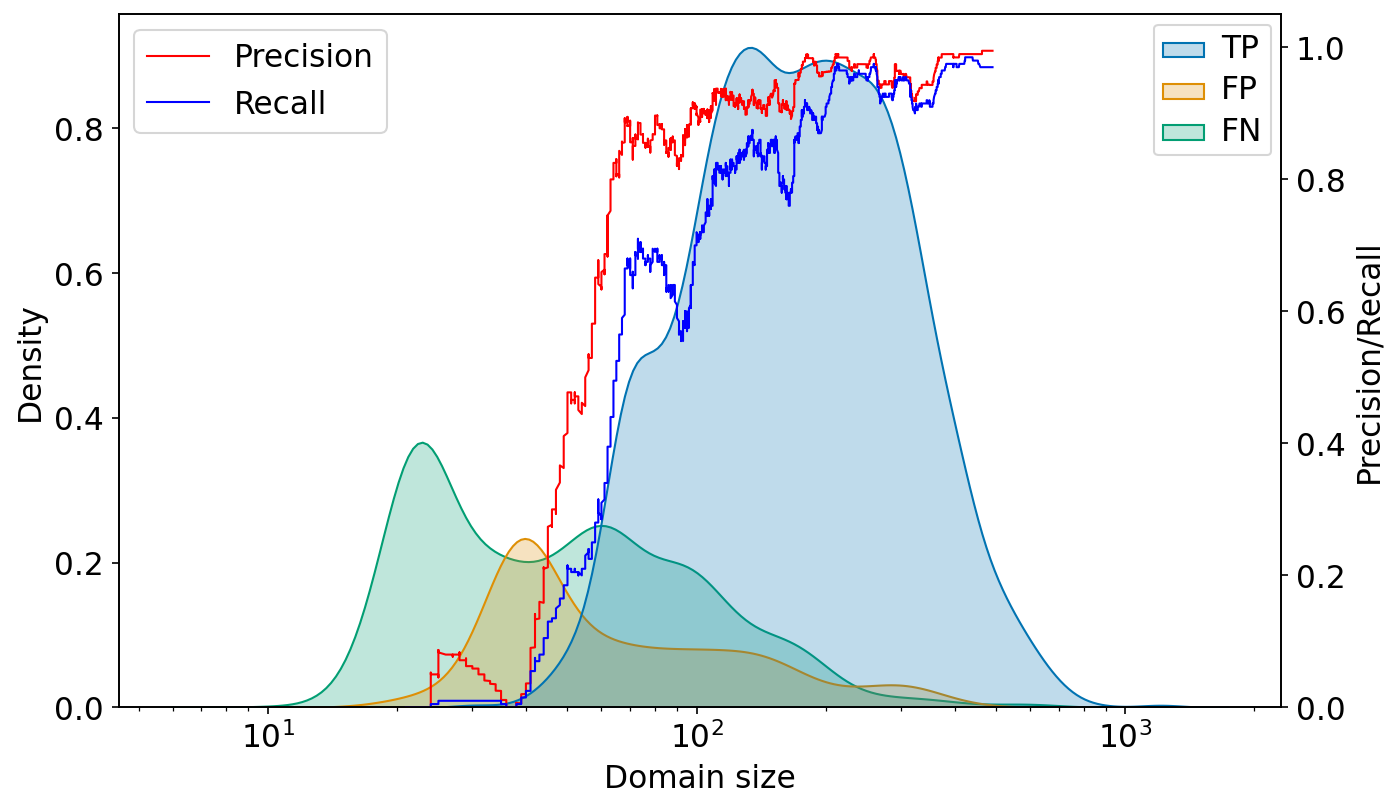

In [52]:
PlotDistributionOfLablesForAColumns(FS_preds_vsPF, "size", "Domain size", log_scale=10)

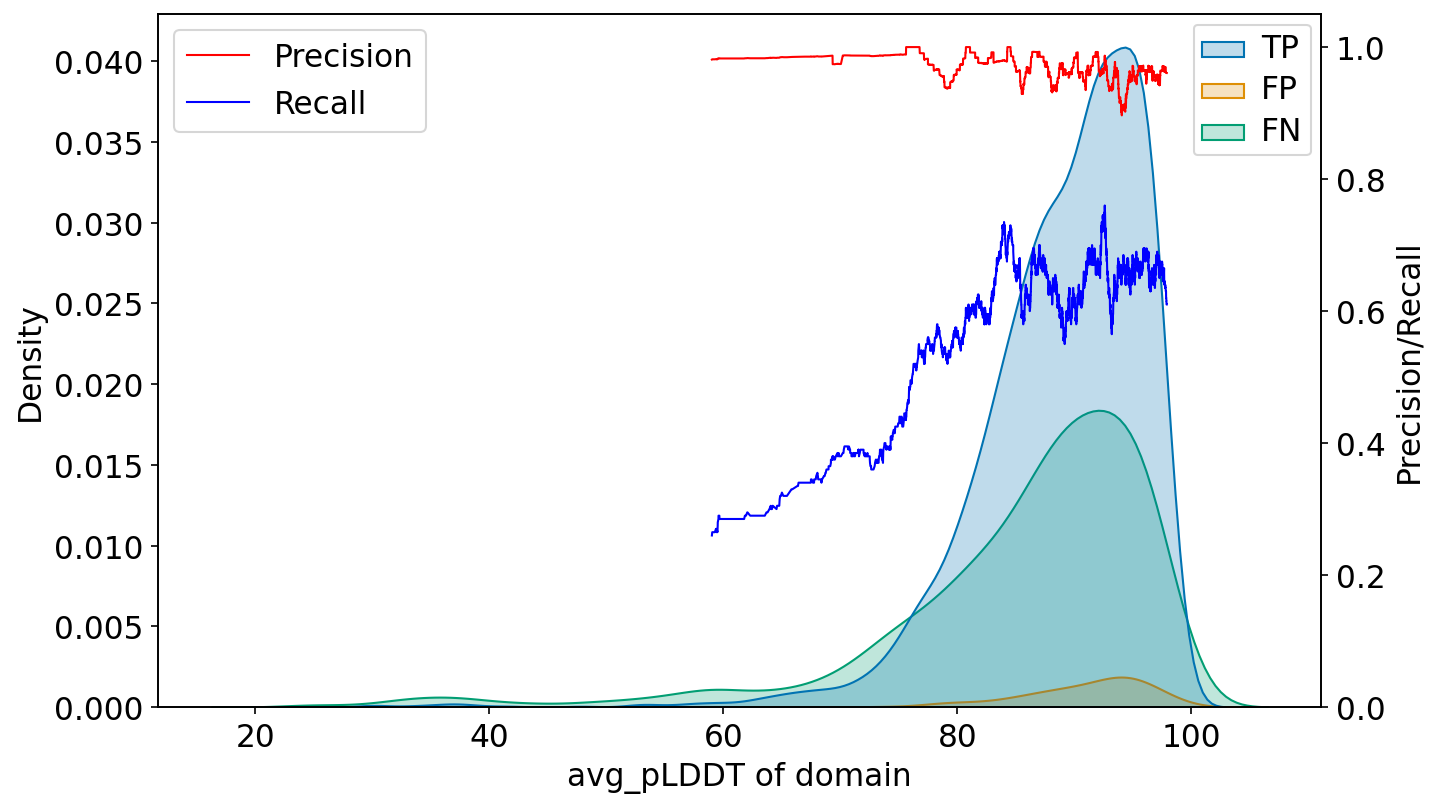

In [53]:
PlotDistributionOfLablesForAColumns(MM_preds_vsPF,  "meanlddt", "avg_pLDDT of domain")

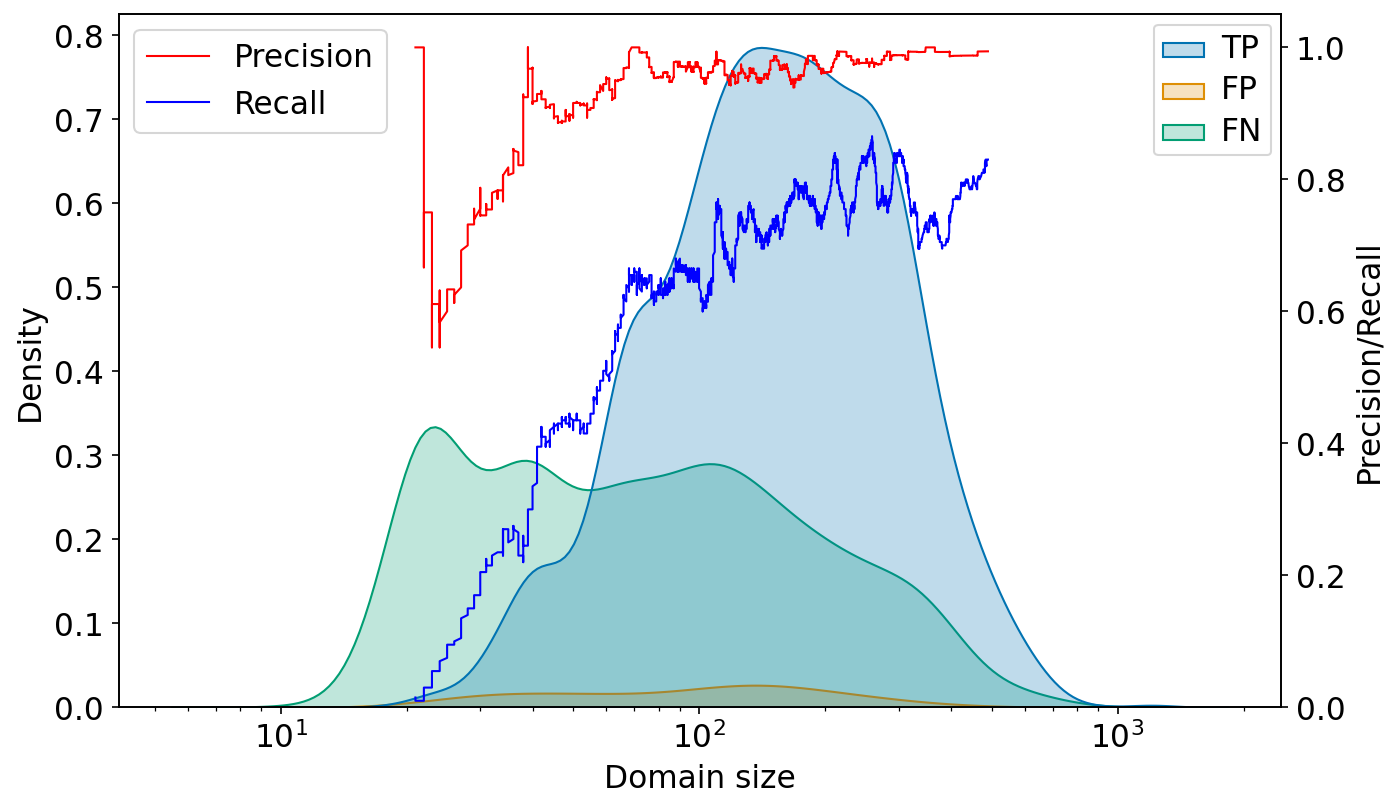

In [69]:
PlotDistributionOfLablesForAColumns(MM_preds_vsPF, "size","Domain size", log_scale=10)

In [40]:
MM_preds_vsPF[MM_preds_vsPF["meanlddt"]<=70]['size'].mean()

127.18834080717488

In [39]:
MM_preds_vsPF[MM_preds_vsPF["meanlddt"]>=70]['size'].mean()

156.17142306209024

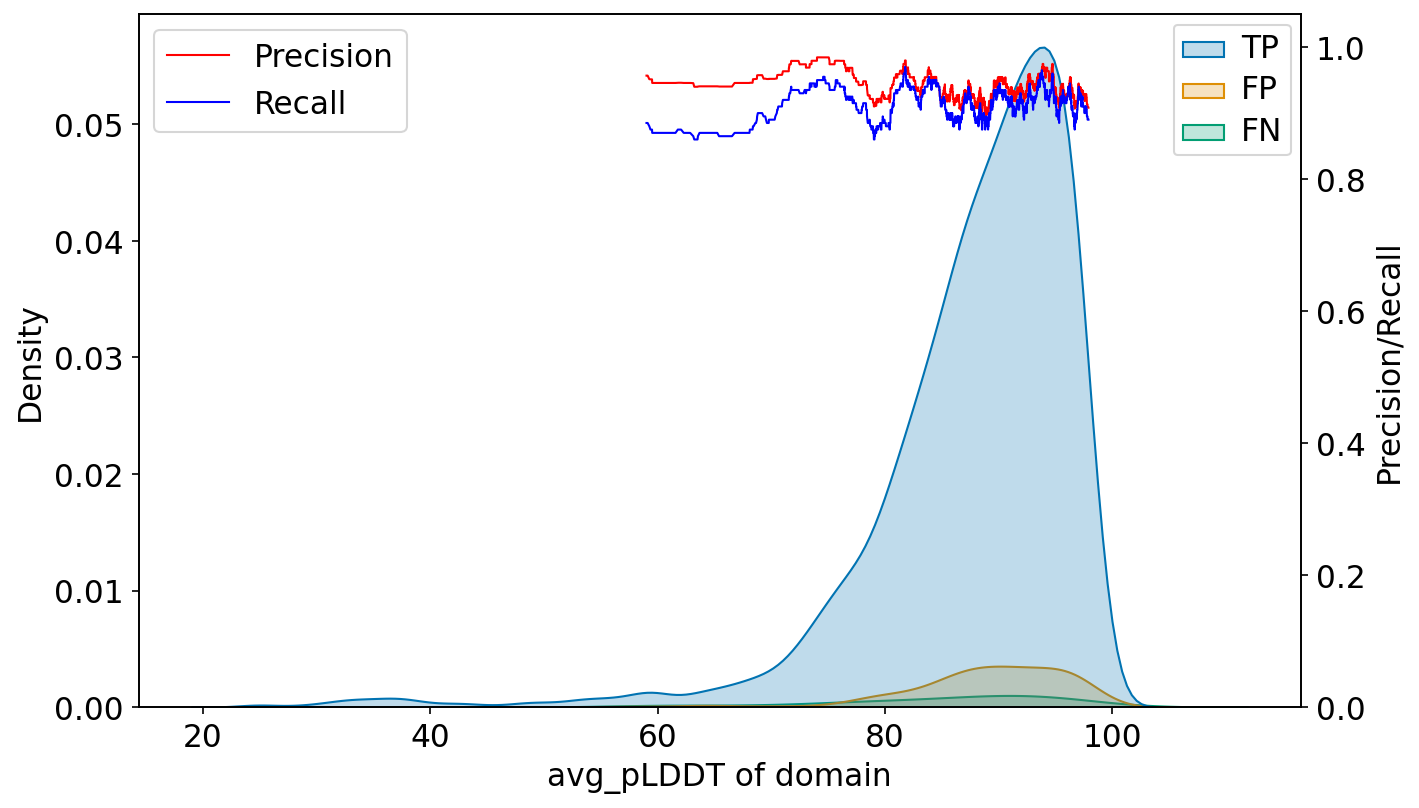

In [54]:
PlotDistributionOfLablesForAColumns(HMMER_preds_vsPF,  "meanlddt", "avg_pLDDT of domain")

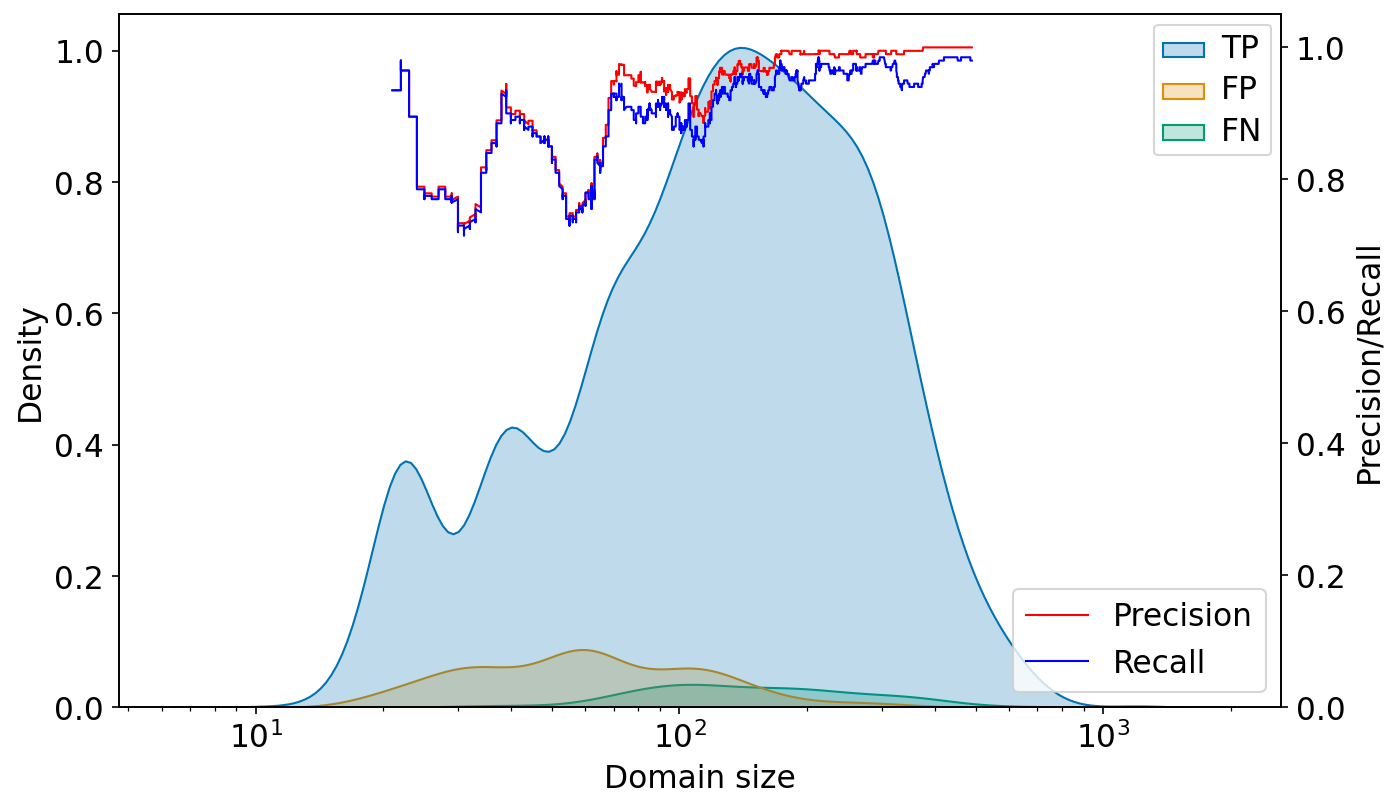

In [55]:
PlotDistributionOfLablesForAColumns(HMMER_preds_vsPF, "size","Domain size", log_scale=10, legen2loc=("lower right"))

In [41]:
correlation, p_value = spearmanr(pf["size"], pf["meanlddt"])
print(correlation)
print(p_value)

-0.0758710672721816
5.275324159949638e-10


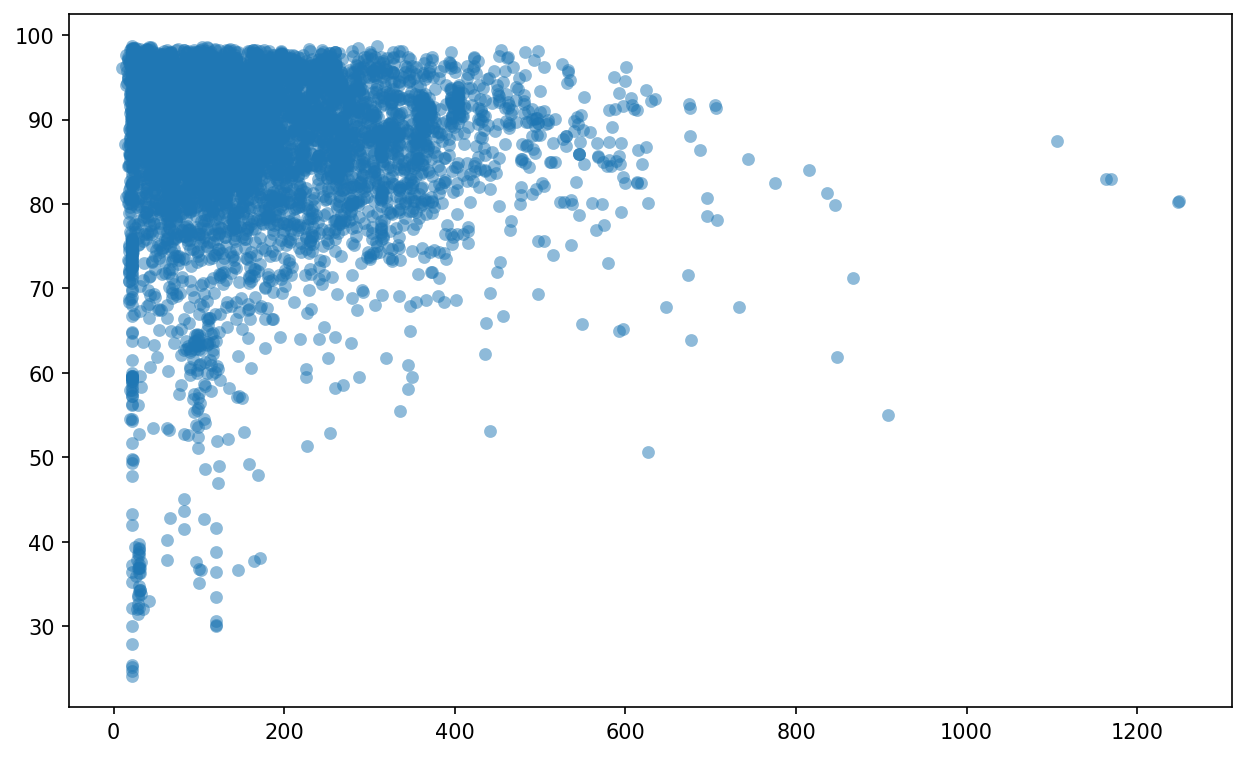

In [42]:
plt.figure(figsize=(10, 6), dpi=150)
plt.scatter(pf["size"], pf["meanlddt"], linewidths=0.1, alpha=0.5)

Now, we want to find the distribution of size and avg_plddt of the retrieved domains 

In [59]:
def calculate_q_average_plddt(row, lddt_dict):
    subset = lddt_dict[row["query"]][int(row["qstart"]-1):int(row["qend"])]
    return np.mean(subset)

In [60]:
def Prep4EffOfQLenAndLDDT(LabeledDf, addrOfpLddtJson="../Tb_plddt.json"):#, typeofaln
    LabeledDf = LabeledDf[LabeledDf['labelcol_str']!="FN"]
    RemovedRed = LabeledDf.drop_duplicates(["query", "target", "qstart", "qend"])
    RemovedRed["qlen"] = RemovedRed["qend"] - RemovedRed["qstart"] + 1
#    if typeofaln == "seq":
#        return RemovedRed
    jsonfile = open(addrOfpLddtJson)
    lddt_dict = json.load(jsonfile)
    RemovedRed["q_avg_plddt"] = RemovedRed.apply(lambda row: calculate_q_average_plddt(row, lddt_dict), axis=1)
    return RemovedRed
    

In [62]:
MM_preds_vsPF_qadj = Prep4EffOfQLenAndLDDT(MM_preds_vsPF) #, "seq")
FS_preds_vsPF_qadj = Prep4EffOfQLenAndLDDT(FS_preds_vsPF) #, "prot")
HMMER_preds_vsPF_qadj = Prep4EffOfQLenAndLDDT(HMMER_preds_vsPF)

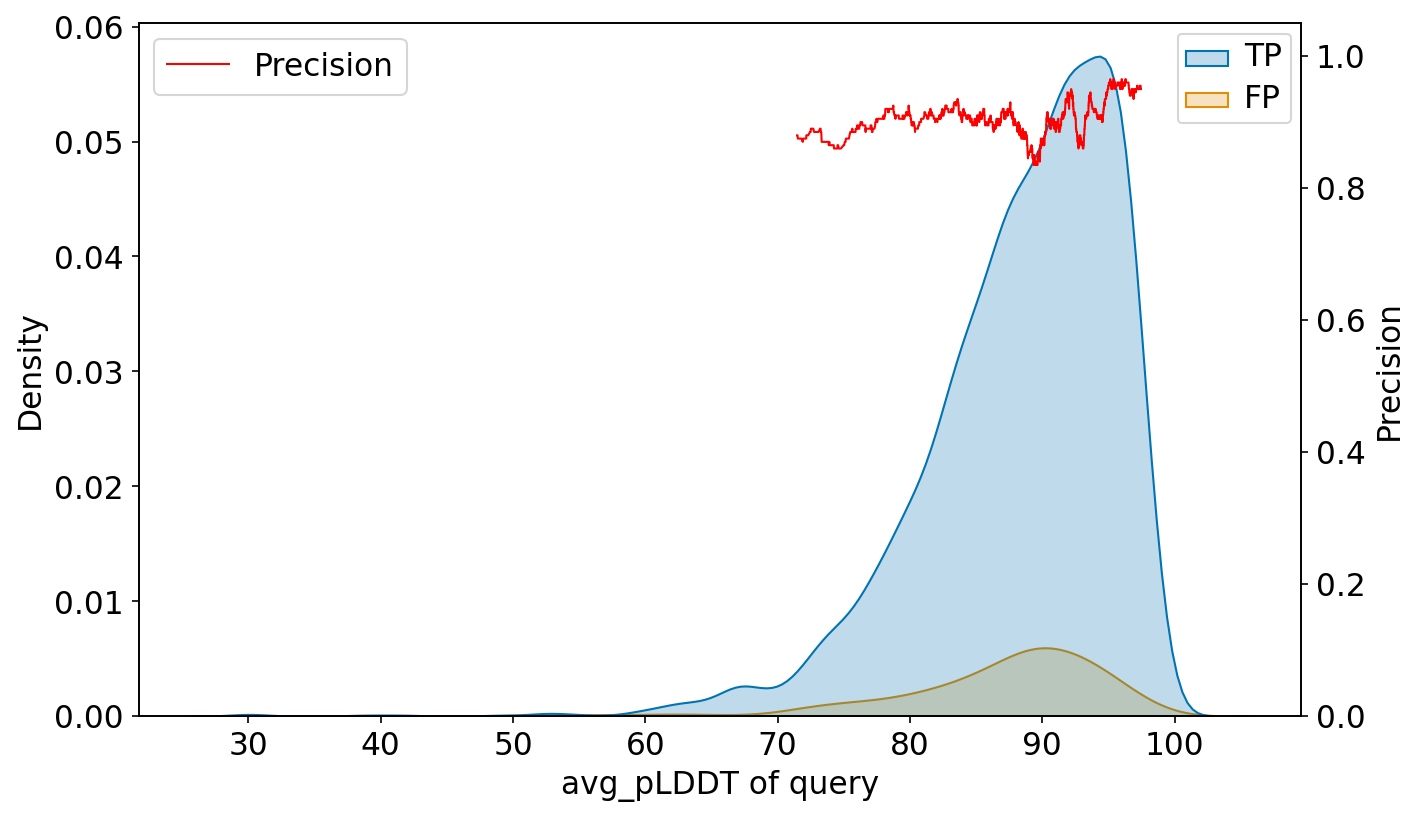

In [63]:
PlotDistributionOfLablesForAColumns(FS_preds_vsPF_qadj, "q_avg_plddt", "avg_pLDDT of query")

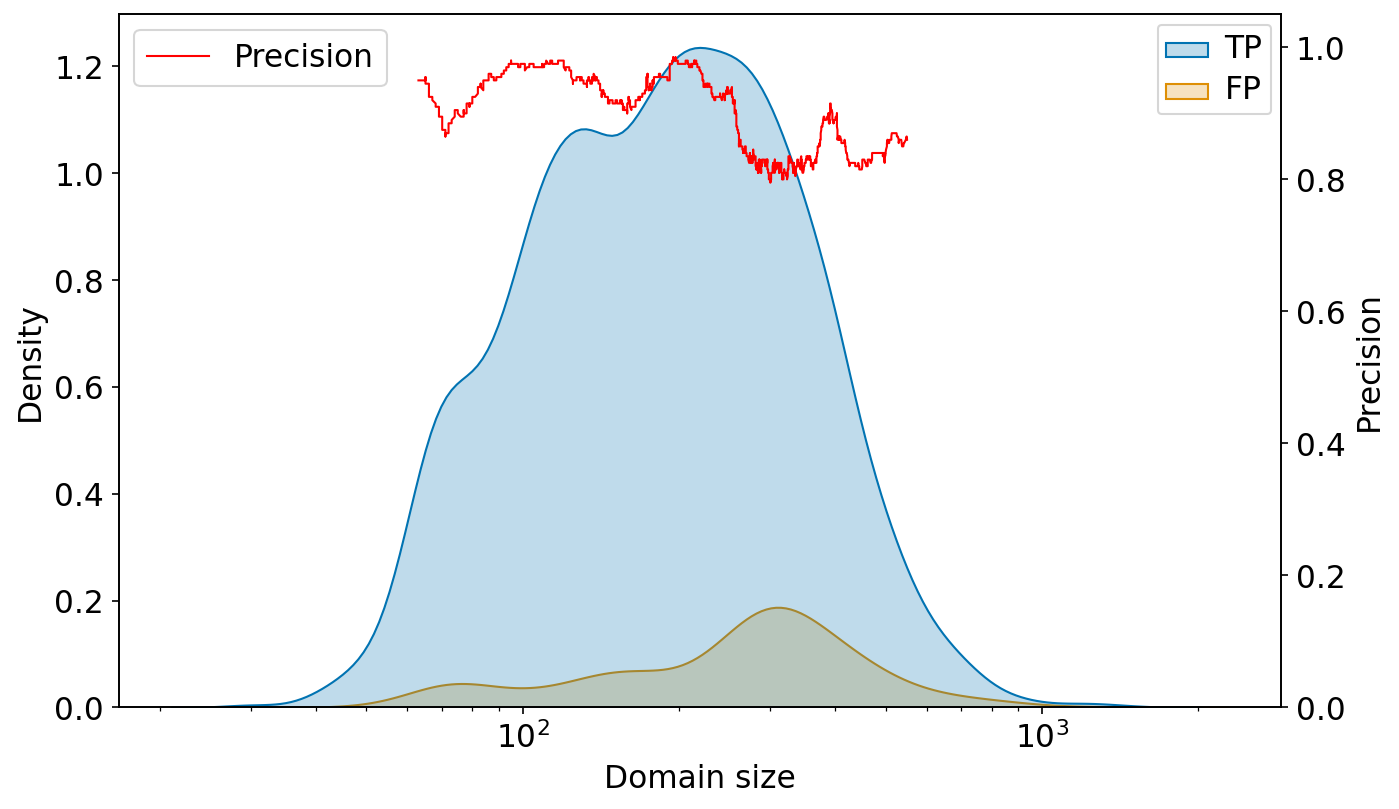

In [64]:
PlotDistributionOfLablesForAColumns(FS_preds_vsPF_qadj, "qlen", "Domain size", log_scale=10)

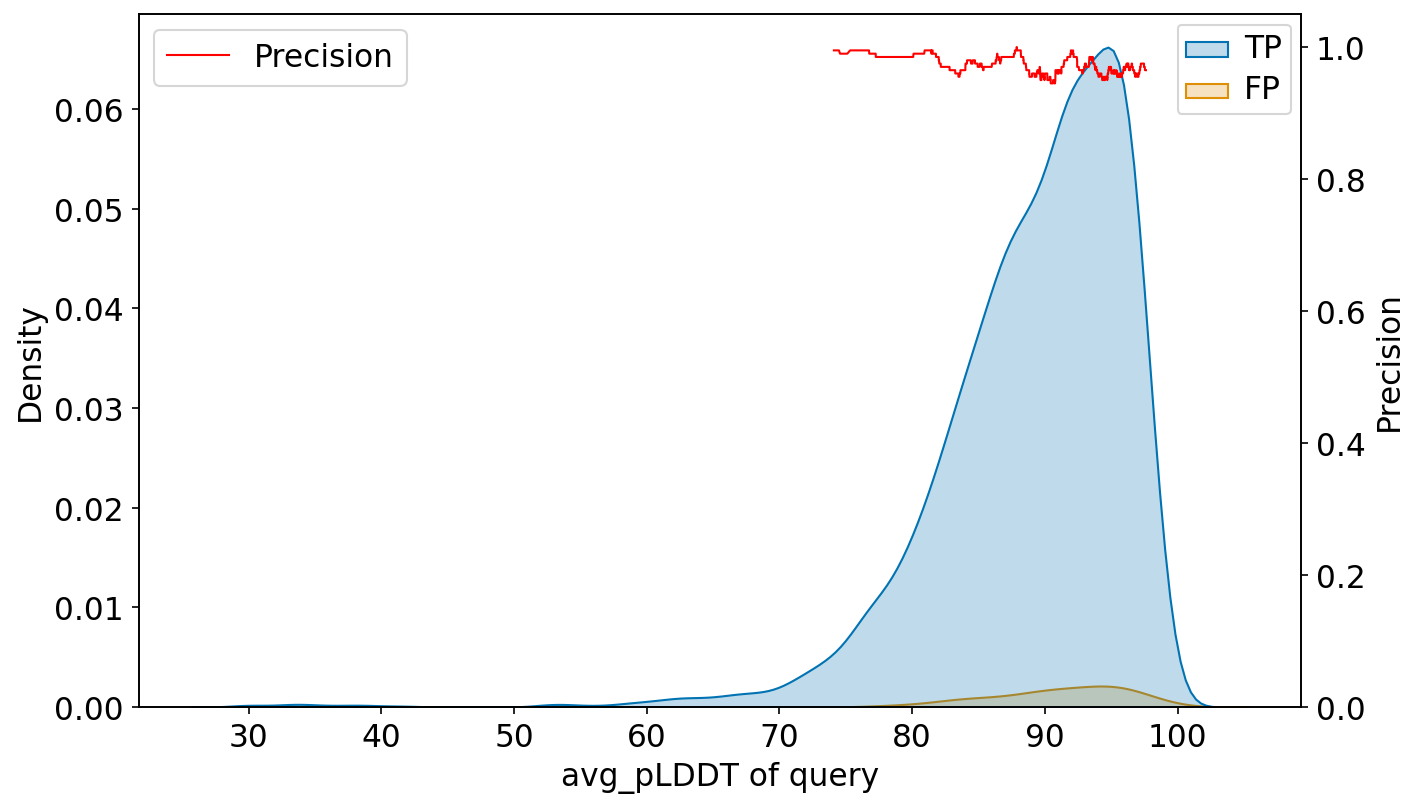

In [65]:
PlotDistributionOfLablesForAColumns(MM_preds_vsPF_qadj, "q_avg_plddt", "avg_pLDDT of query")

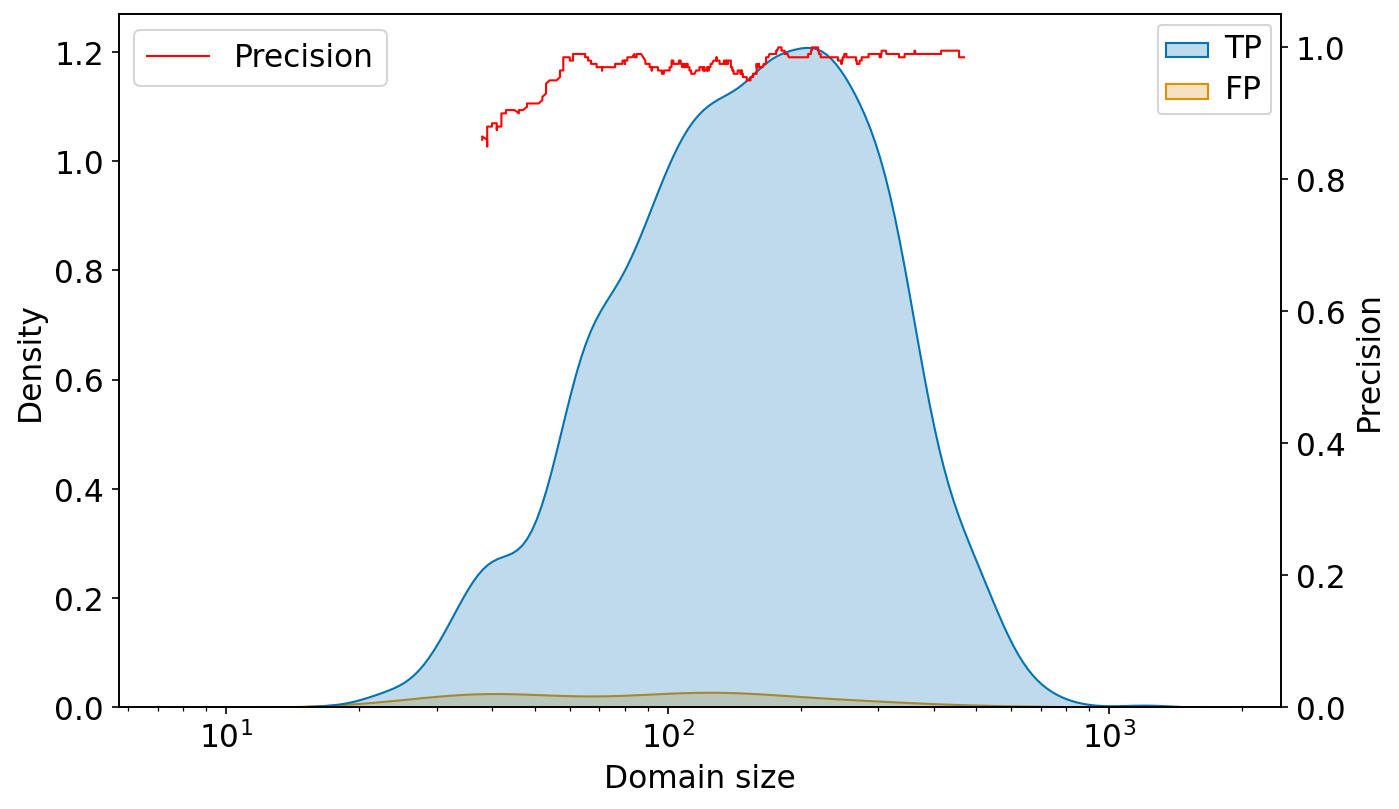

In [66]:
PlotDistributionOfLablesForAColumns(MM_preds_vsPF_qadj, "qlen", "Domain size", log_scale=10)

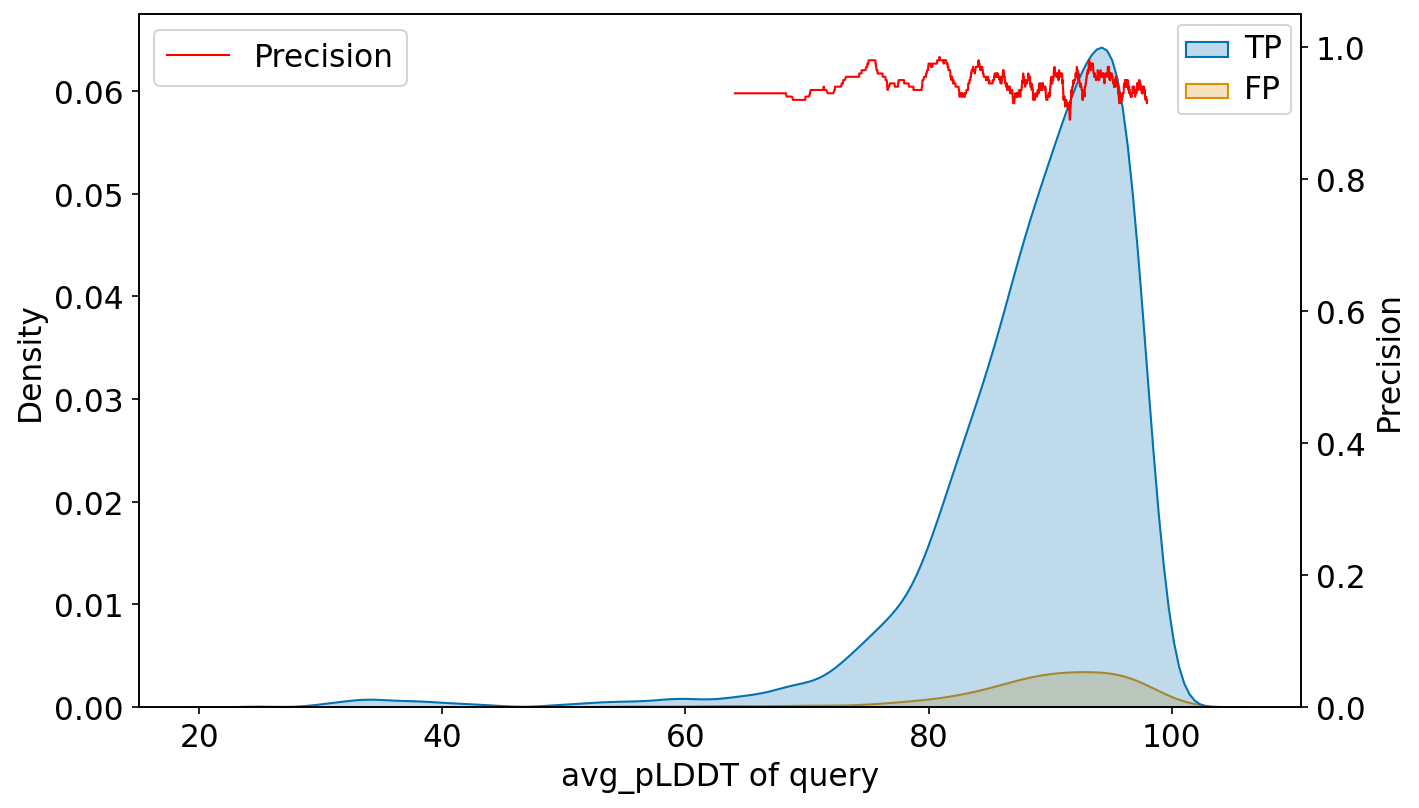

In [67]:
PlotDistributionOfLablesForAColumns(HMMER_preds_vsPF_qadj, "q_avg_plddt", "avg_pLDDT of query")

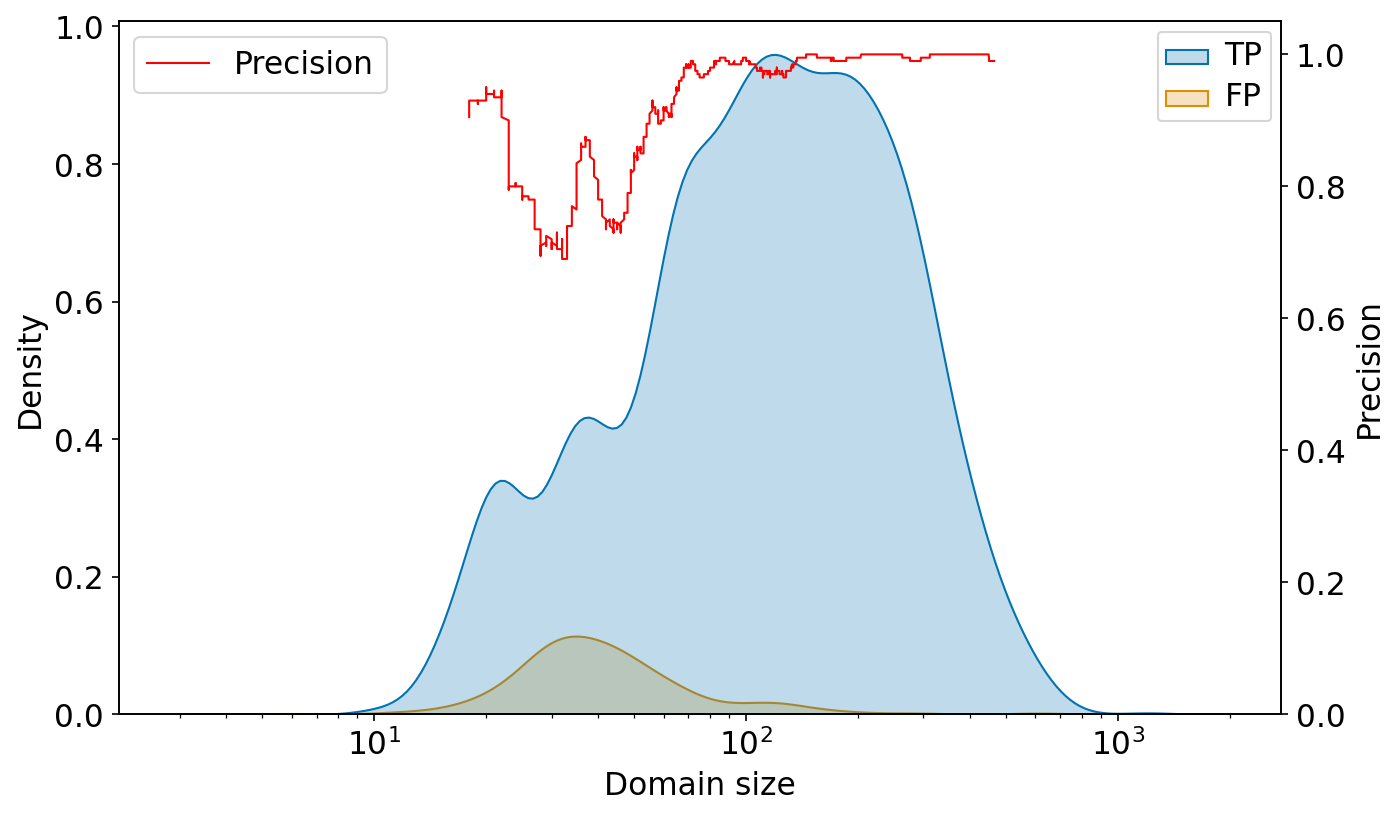

In [68]:
PlotDistributionOfLablesForAColumns(HMMER_preds_vsPF_qadj, "qlen", "Domain size", log_scale=10)

# Pfam-N as the Gold Standard

In [69]:
pfn = pd.read_csv("../PfamNTb_SeedMeanlddtSize.txt",sep="\t")
FS_preds_vsPFn = OneHotEncodingLabel(Labeler("../aln_Tb_pf_gr_fmt.tsv", clanassociation, pfn, instance_database = True, bitscutoff=152))
FS_preds_vsPFn_nobits = OneHotEncodingLabel(Labeler("../aln_Tb_pf_gr_fmt.tsv", clanassociation, pfn, instance_database = True))
MM_preds_vsPFn = OneHotEncodingLabel(Labeler("../aln_Tb_pf_gr_seq_fmt.tsv", clanassociation, pfn, instance_database = True))
HMMER_preds_vsPFn = OneHotEncodingLabel(Labeler("../HmmerGreedyHits.tsv", clanassociation, pfn, instance_database = False))
#HMMER_preds_vsPF = OneHotEncodingLabel(Labeler("../HmmerGreedyHits.tsv", clanassociation, pf, instance_database = False ))

In [70]:
FS_preds_PFn_ov_precision_pf_level,FS_preds_PFn_ov_recall_pf_level = PrecisionRecall(FS_preds_vsPFn, "equaltopfampreds")
print("The followings are for Pfam-level Foldseek annotation when Pfam-N is considered as the Gold Standard")
print("Precision is {} ".format(FS_preds_PFn_ov_precision_pf_level))
print("Recall is {} ".format(FS_preds_PFn_ov_recall_pf_level))

The followings are for Pfam-level Foldseek annotation when Pfam-N is considered as the Gold Standard
Precision is 0.7553342816500711 
Recall is 0.45257518568123706 


In [71]:
FS_preds_PFn_ov_precision_pf_level,FS_preds_PFn_ov_recall_pf_level = PrecisionRecall(FS_preds_vsPFn_nobits, "equaltopfampreds")
print("The followings are for Pfam-level Foldseek annotation when Pfam-N is considered as the Gold Standard, without bitscore threshold")
print("Precision is {} ".format(FS_preds_PFn_ov_precision_pf_level))
print("Recall is {} ".format(FS_preds_PFn_ov_recall_pf_level))

The followings are for Pfam-level Foldseek annotation when Pfam-N is considered as the Gold Standard, without bitscore threshold
Precision is 0.7212497647280256 
Recall is 0.46657737732862536 


In [72]:
FS_preds_PFn_ov_precision_clan_level,FS_preds_PFn_ov_recall_clan_level = PrecisionRecall(FS_preds_vsPFn, "pfamclanisidentical")
print("The followings are for Clan-level Foldseek annotation when Pfam-N is considered as the Gold Standard")
print("Precision is {} ".format(FS_preds_PFn_ov_precision_clan_level))
print("Recall is {} ".format(FS_preds_PFn_ov_recall_clan_level))

The followings are for Clan-level Foldseek annotation when Pfam-N is considered as the Gold Standard
Precision is 0.9575289575289575 
Recall is 0.5737245829782053 


Let's see the difference in the size of domains predicted by Foldseek and those predicted by Pfam v35.

(-400.0, 2000.0)

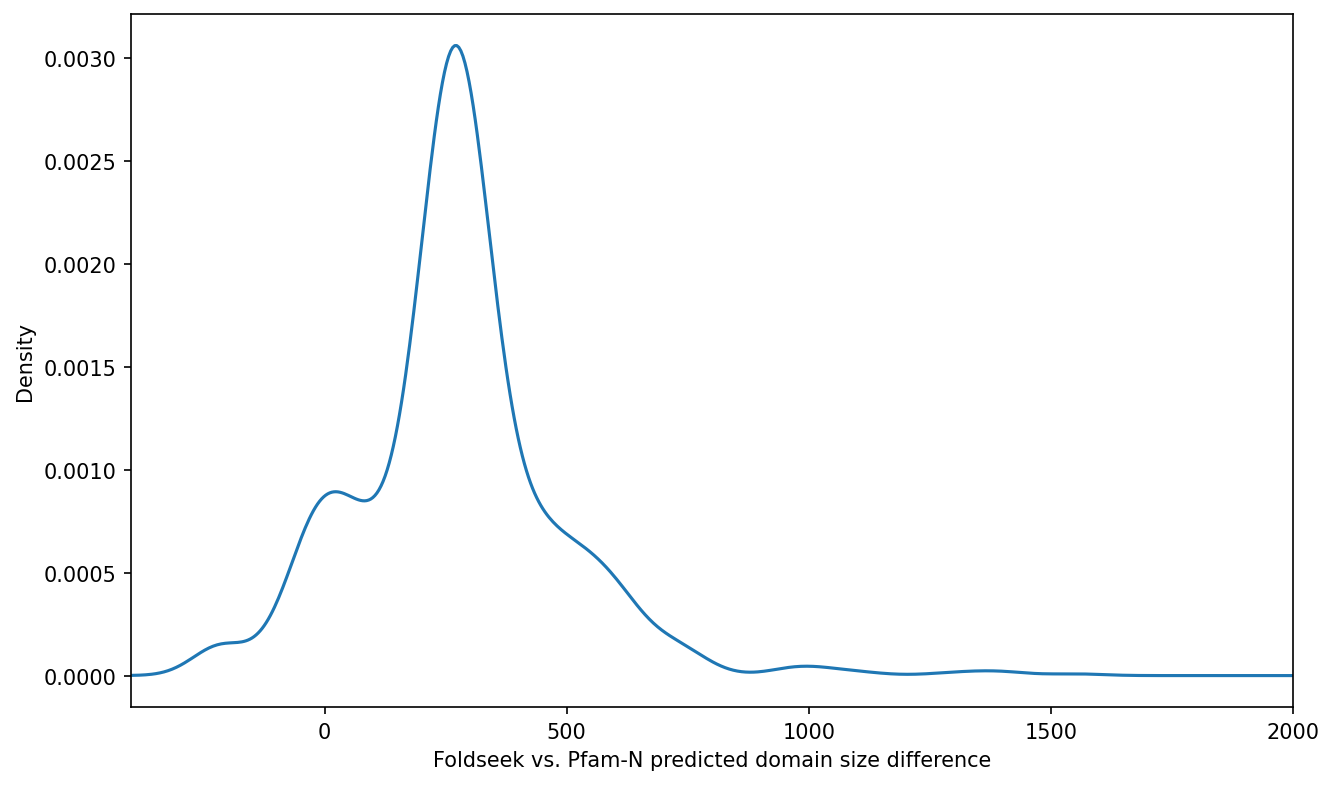

In [73]:
FPs_PFn = FS_preds_vsPFn[FS_preds_vsPFn["labelcol_str"]=="FP"]
FPs_PFn = FPs_PFn[(FPs_PFn["qend"] - FPs_PFn["qstart"]+1)>=200]
plt.figure(figsize=(10, 6), dpi=150)
((FPs_PFn["qend"] - FPs_PFn["qstart"]) - (FPs_PFn["pfend"] - FPs_PFn["pfstart"])).plot.kde()
plt.xlabel("Foldseek vs. Pfam-N predicted domain size difference")
plt.xlim((-400, 2000))

In [81]:
MM_preds_PFn_ov_precision_clan_level,MM_preds_PFn_ov_recall_clan_level = PrecisionRecall(MM_preds_vsPFn, "equaltopfampreds")
print("The followings are for Pfam-level MMseqs2 annotation when Pfam-N is considered as the Gold Standard")
print("Precision is {} ".format(MM_preds_PFn_ov_precision_clan_level))
print("Recall is {} ".format(MM_preds_PFn_ov_recall_clan_level))

The followings are for Pfam-level MMseqs2 annotation when Pfam-N is considered as the Gold Standard
Precision is 0.9040635502597005 
Recall is 0.3602824789967125 


In [82]:
MM_preds_PFn_ov_precision_clan_level,MM_preds_PFn_ov_recall_clan_level = PrecisionRecall(MM_preds_vsPFn, "pfamclanisidentical")
print("The followings are for Pfam-level MMseqs2 annotation when Pfam-N is considered as the Gold Standard")
print("Precision is {} ".format(MM_preds_PFn_ov_precision_clan_level))
print("Recall is {} ".format(MM_preds_PFn_ov_recall_clan_level))

The followings are for Pfam-level MMseqs2 annotation when Pfam-N is considered as the Gold Standard
Precision is 0.9911396272532844 
Recall is 0.39498356264458784 


In [83]:
HMMER_preds_PFn_ov_precision_clan_level,HMMER_preds_PFn_ov_recall_clan_level = PrecisionRecall(HMMER_preds_vsPFn, "equaltopfampreds")
print("The followings are for Pfam-level HMMER annotation when Pfam-N is considered as the Gold Standard")
print("Precision is {} ".format(HMMER_preds_PFn_ov_precision_clan_level))
print("Recall is {} ".format(HMMER_preds_PFn_ov_recall_clan_level))

The followings are for Pfam-level HMMER annotation when Pfam-N is considered as the Gold Standard
Precision is 0.8353777777777778 
Recall is 0.5721417265311092 


In [84]:
HMMER_preds_PFn_ov_precision_clan_level,HMMER_preds_PFn_ov_recall_clan_level = PrecisionRecall(HMMER_preds_vsPFn, "pfamclanisidentical")
print("The followings are for Pfam-level HMMER annotation when Pfam-N is considered as the Gold Standard")
print("Precision is {} ".format(HMMER_preds_PFn_ov_precision_clan_level))
print("Recall is {} ".format(HMMER_preds_PFn_ov_recall_clan_level))

The followings are for Pfam-level HMMER annotation when Pfam-N is considered as the Gold Standard
Precision is 0.9607111111111111 
Recall is 0.6579812492390114 


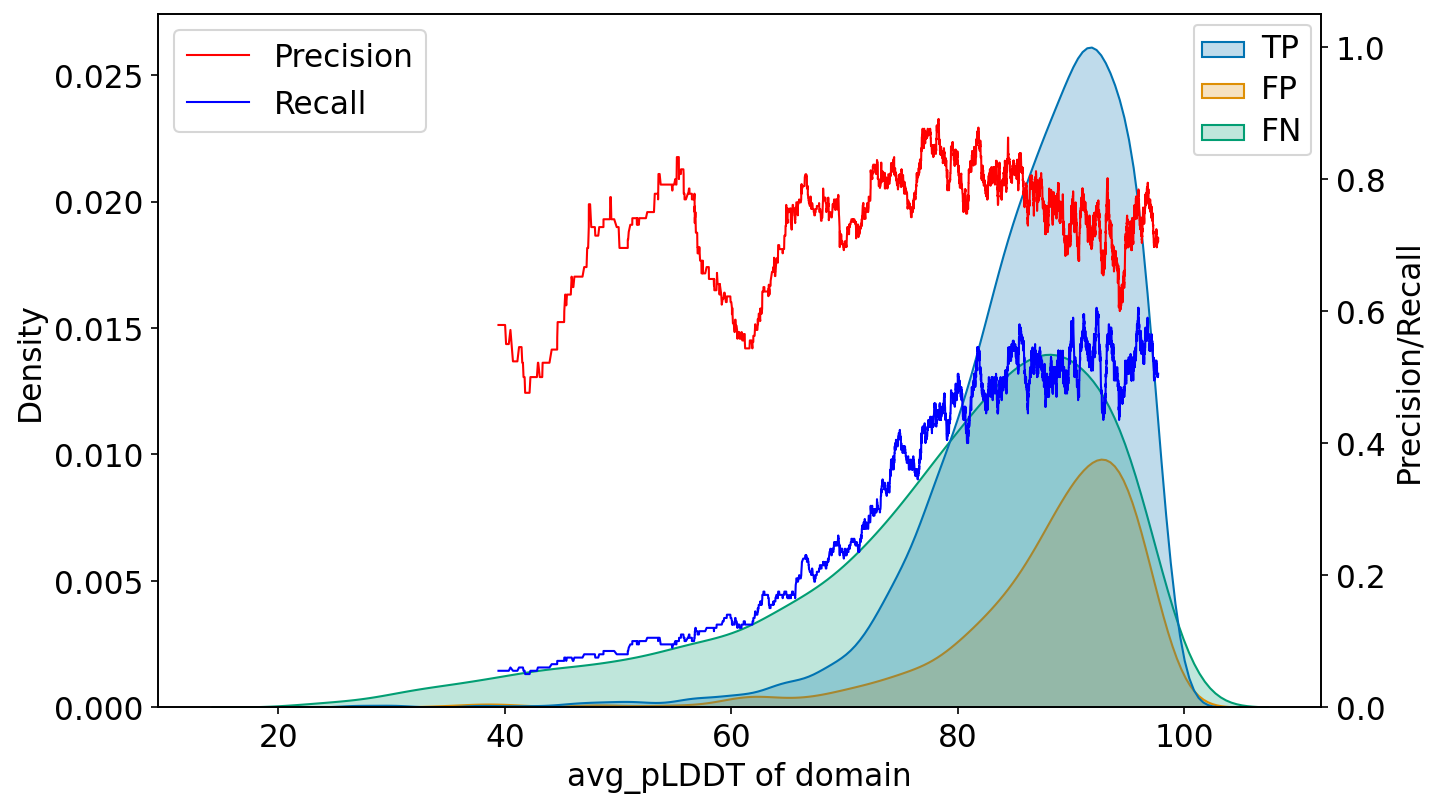

In [85]:
PlotDistributionOfLablesForAColumns(FS_preds_vsPFn, "meanlddt","avg_pLDDT of domain")

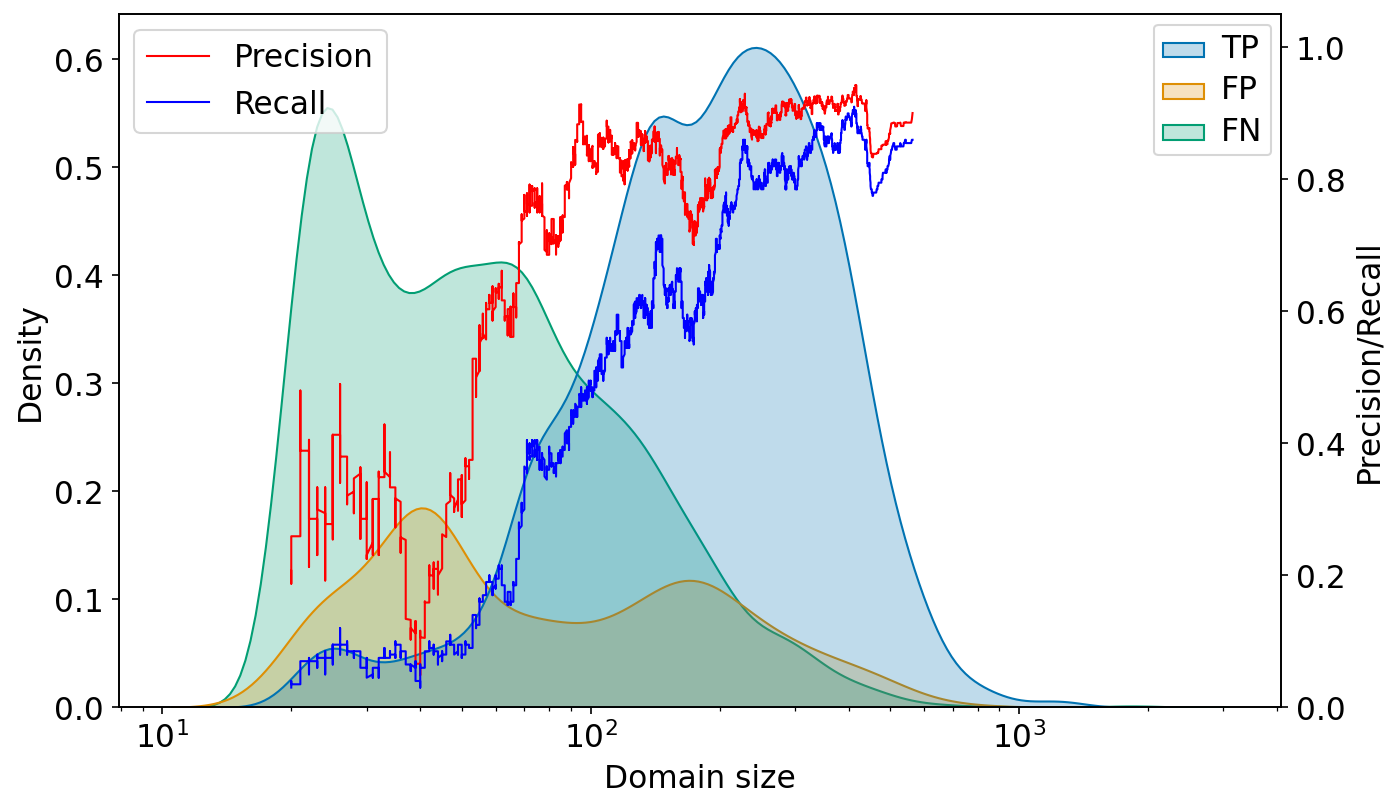

In [86]:
PlotDistributionOfLablesForAColumns(FS_preds_vsPFn,"size","Domain size", log_scale=10)

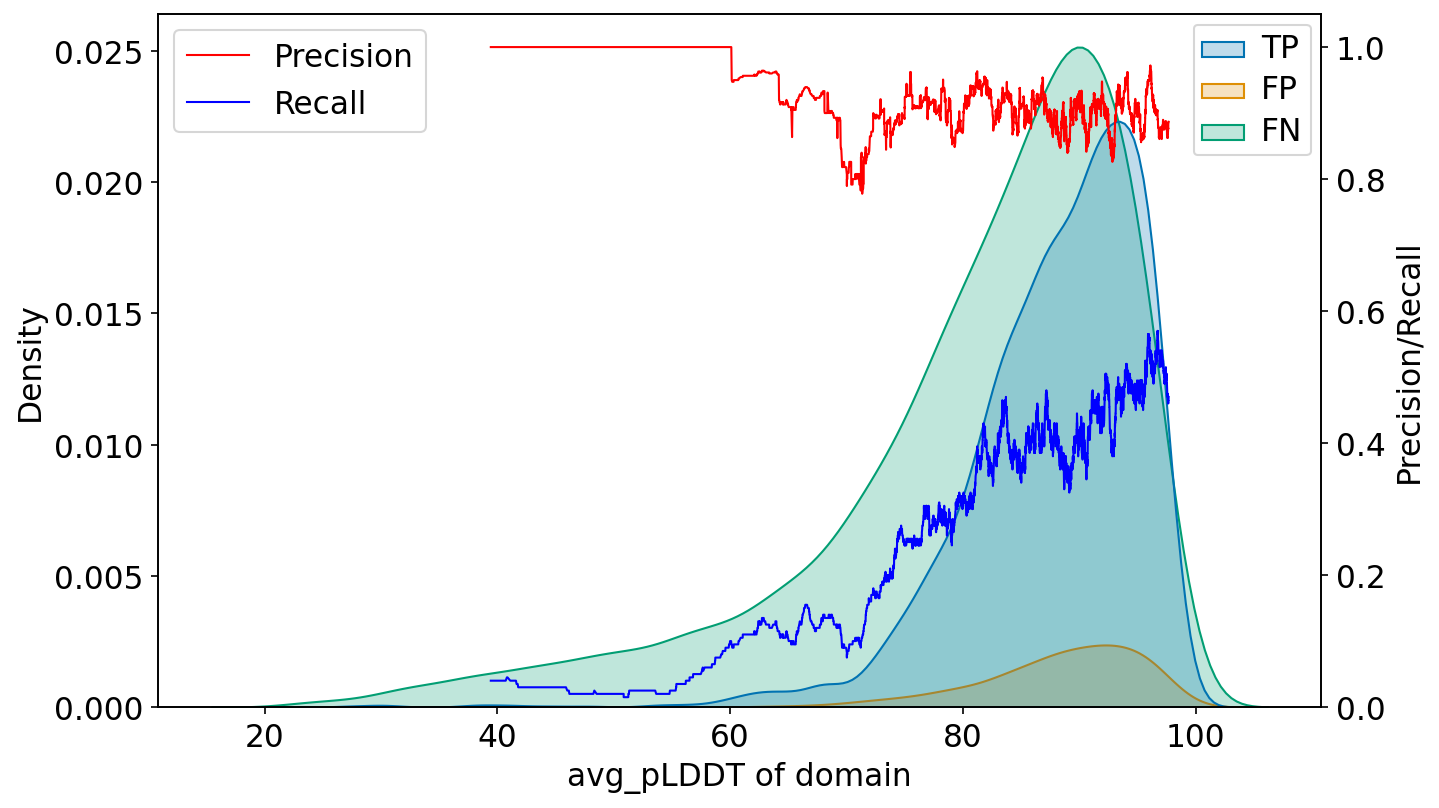

In [87]:
PlotDistributionOfLablesForAColumns(MM_preds_vsPFn, "meanlddt","avg_pLDDT of domain")

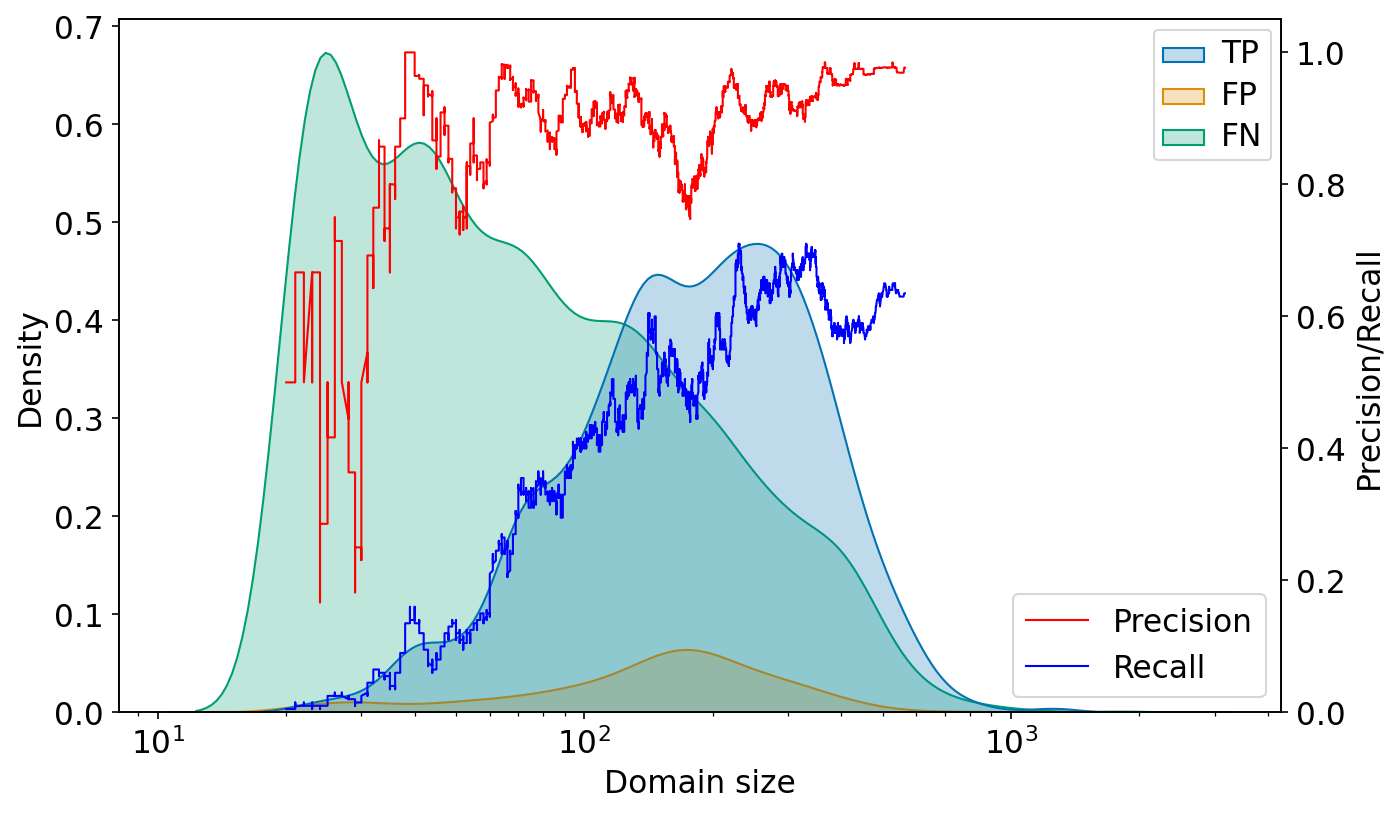

In [88]:
PlotDistributionOfLablesForAColumns(MM_preds_vsPFn, "size","Domain size",log_scale=10, legen2loc=("lower right"))

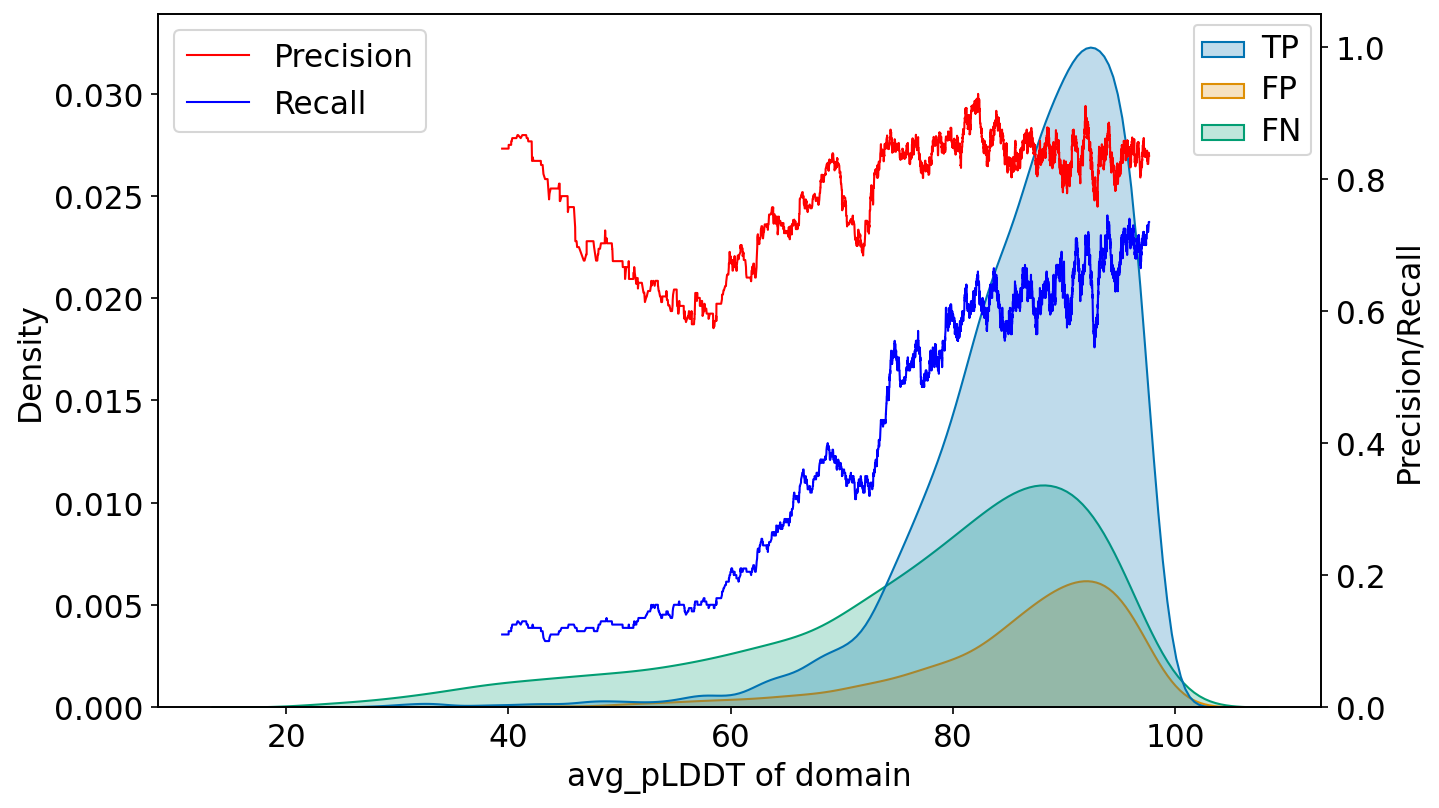

In [89]:
PlotDistributionOfLablesForAColumns(HMMER_preds_vsPFn, "meanlddt","avg_pLDDT of domain")

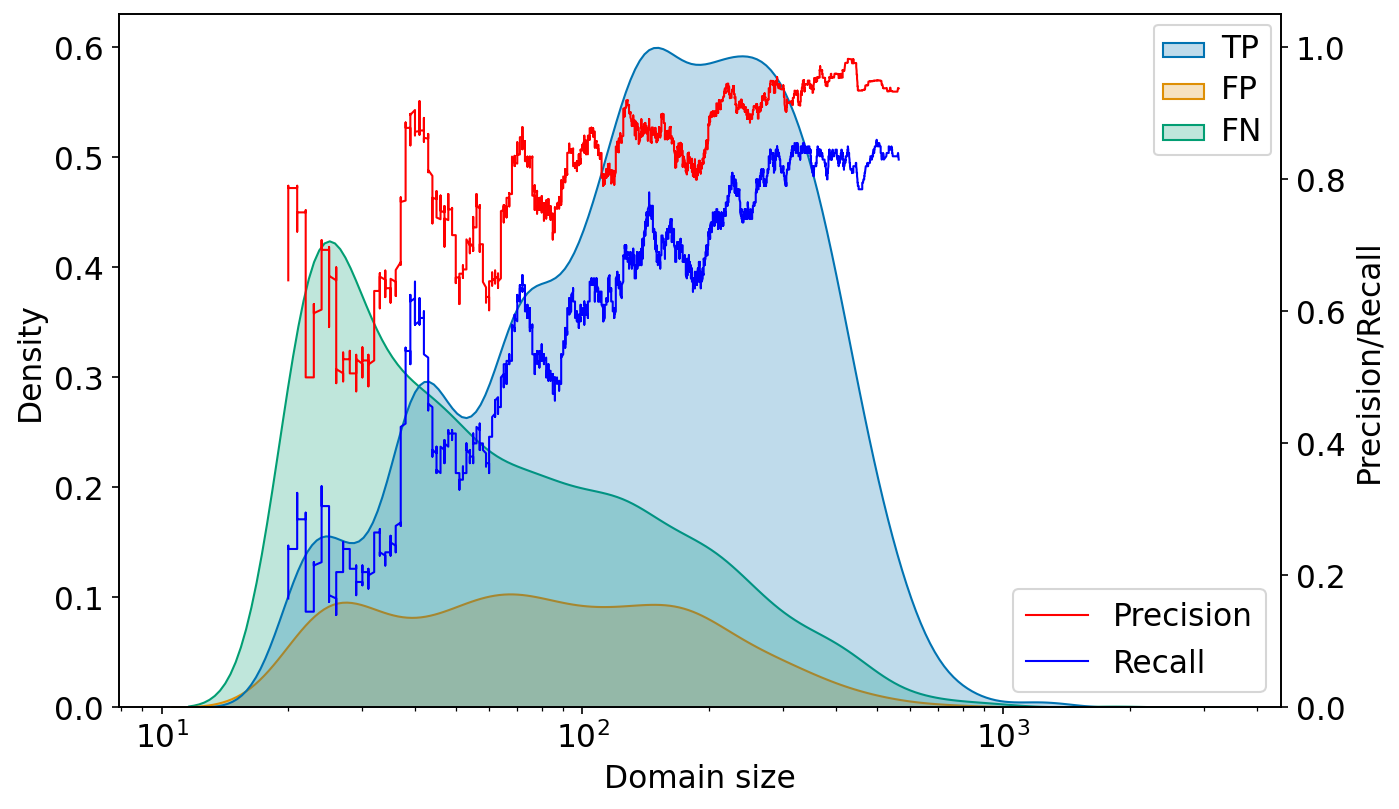

In [90]:
PlotDistributionOfLablesForAColumns(HMMER_preds_vsPFn, "size","Domain size",log_scale=10, legen2loc=("lower right"))

The following plots are for showing the distribution of query characteristics according to the label

In [96]:
MM_preds_vsPFn_qadj = Prep4EffOfQLenAndLDDT(MM_preds_vsPFn) #, "seq"
FS_preds_vsPFn_qadj = Prep4EffOfQLenAndLDDT(FS_preds_vsPFn) #, "prot")
HMMER_preds_vsPFn_qadj = Prep4EffOfQLenAndLDDT(HMMER_preds_vsPFn) #, "prot")

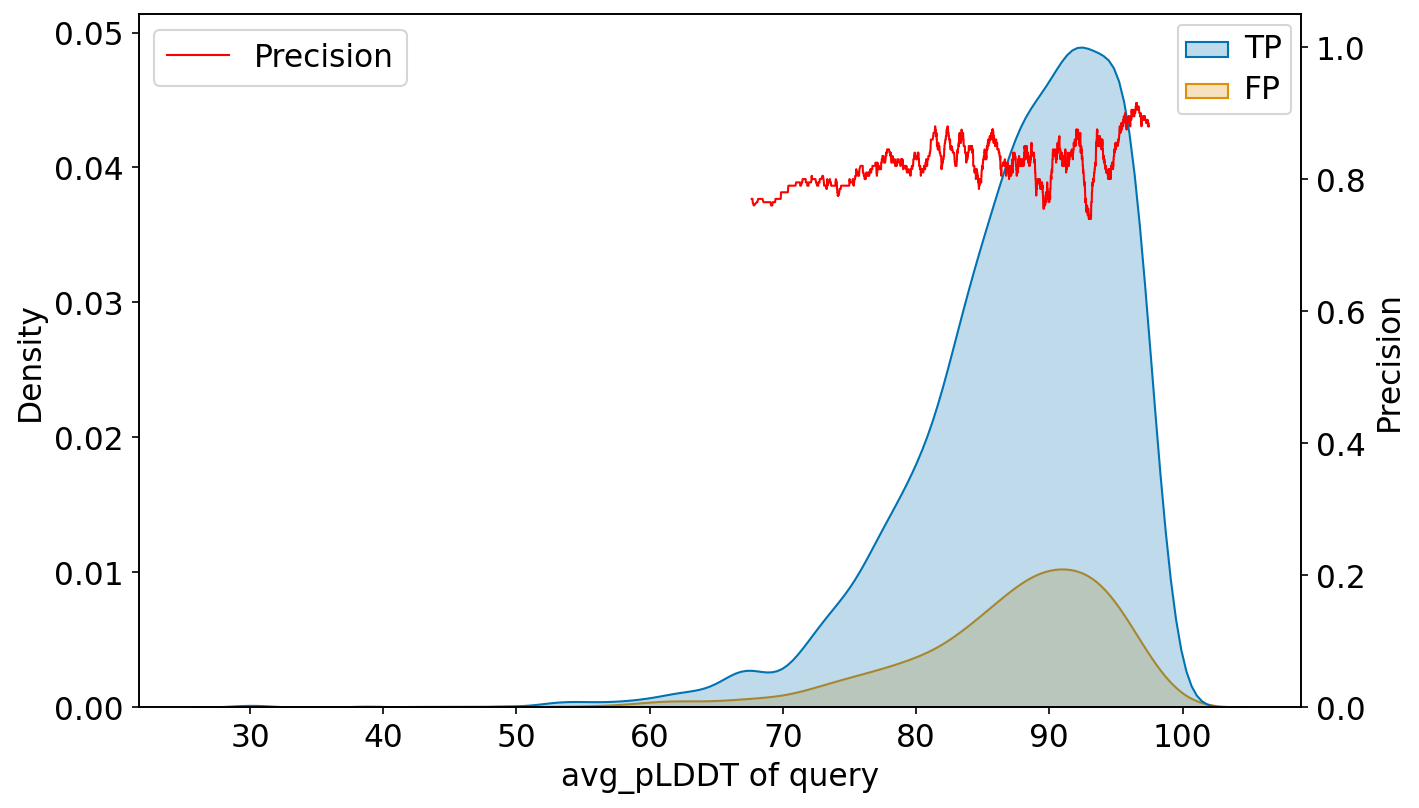

In [97]:
PlotDistributionOfLablesForAColumns(FS_preds_vsPFn_qadj, "q_avg_plddt", "avg_pLDDT of query")

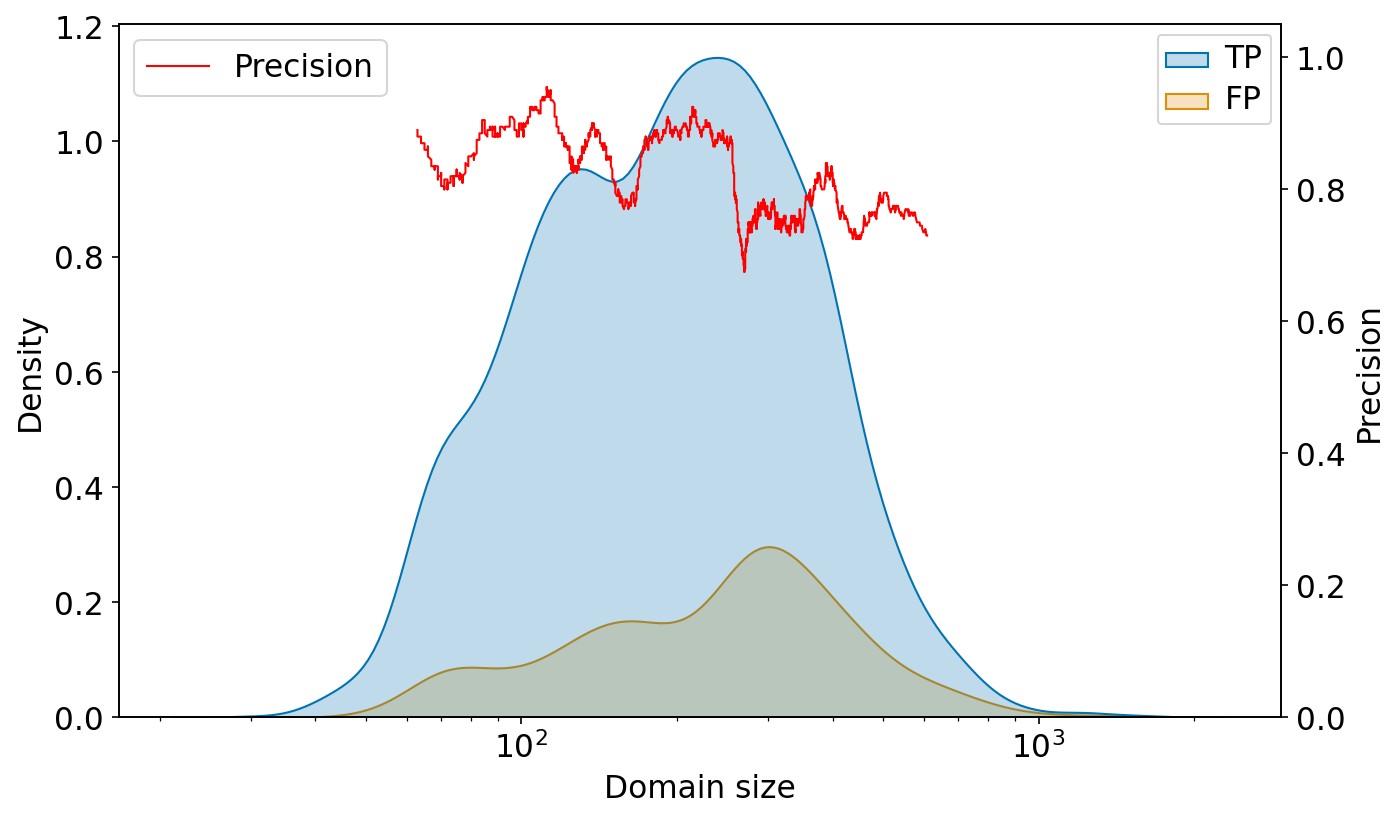

In [98]:
PlotDistributionOfLablesForAColumns(FS_preds_vsPFn_qadj, "qlen", "Domain size", log_scale=10)

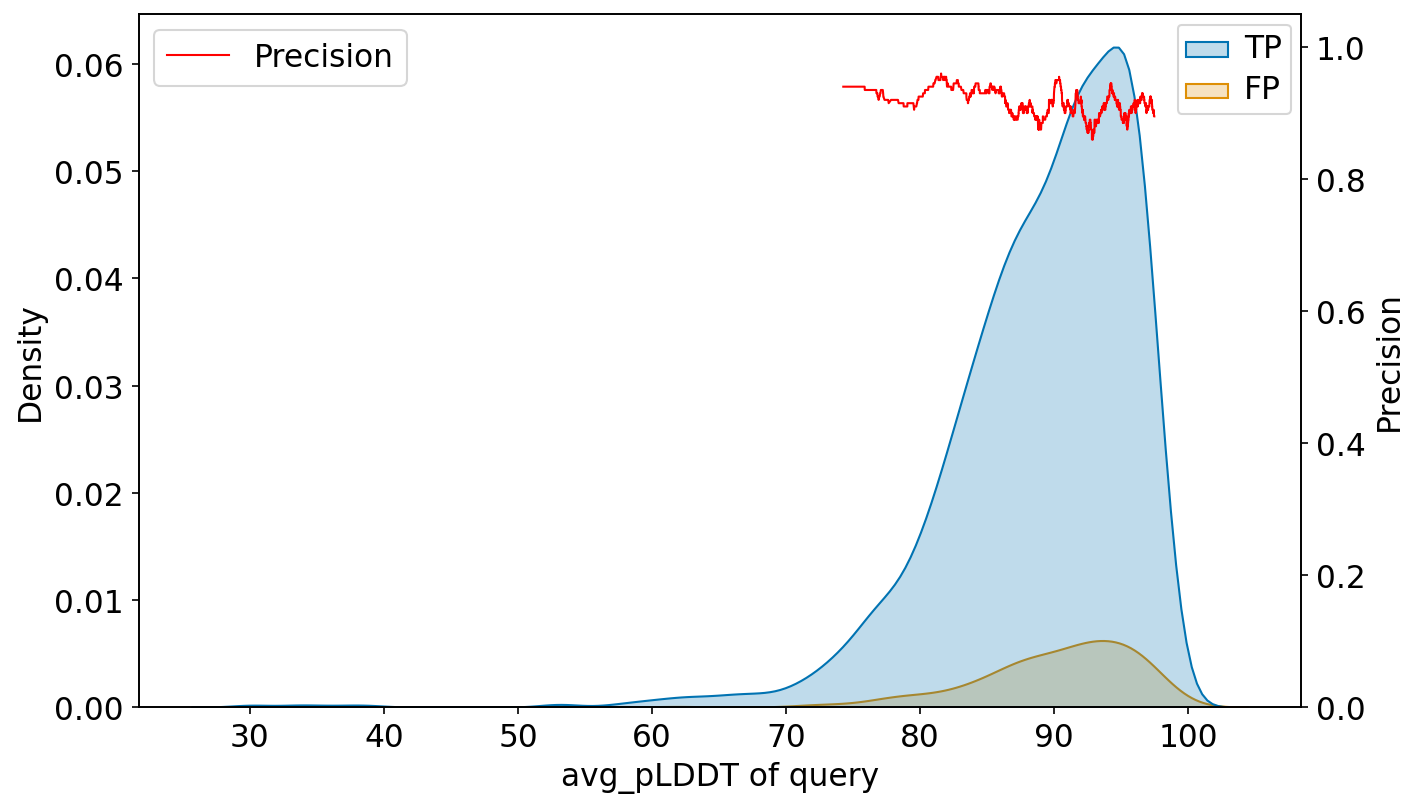

In [99]:
PlotDistributionOfLablesForAColumns(MM_preds_vsPFn_qadj, "q_avg_plddt", "avg_pLDDT of query")

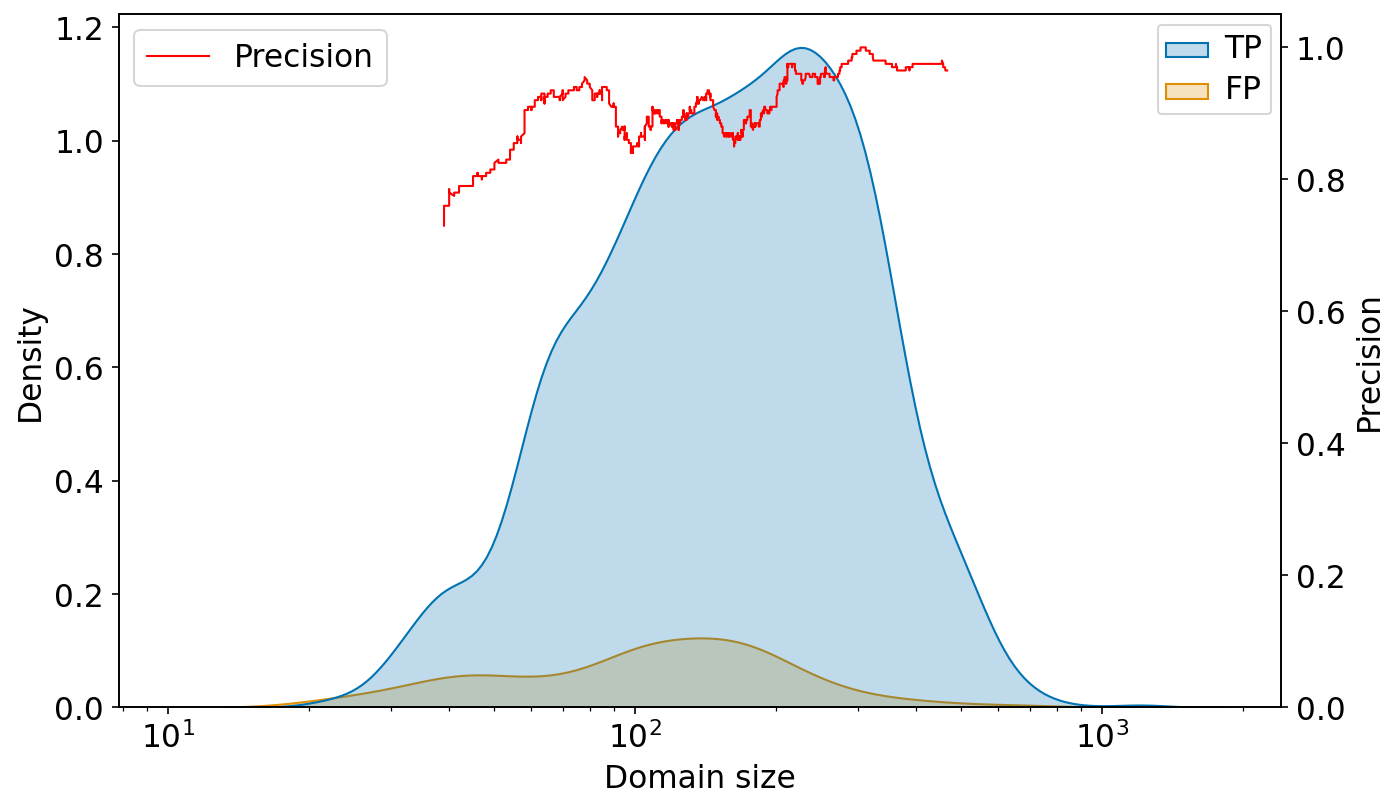

In [100]:
PlotDistributionOfLablesForAColumns(MM_preds_vsPFn_qadj, "qlen", "Domain size", log_scale=10)

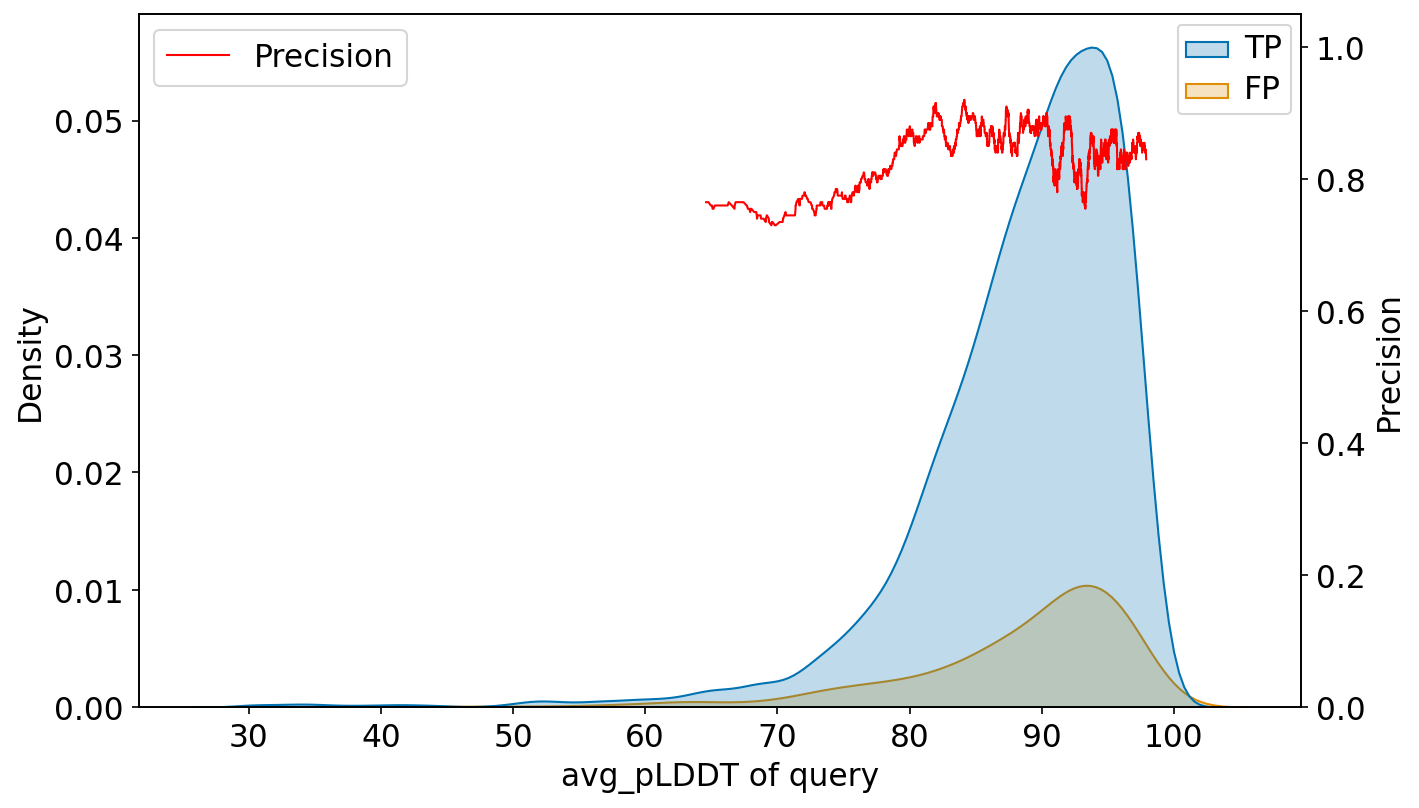

In [101]:
PlotDistributionOfLablesForAColumns(HMMER_preds_vsPFn_qadj, "q_avg_plddt", "avg_pLDDT of query")

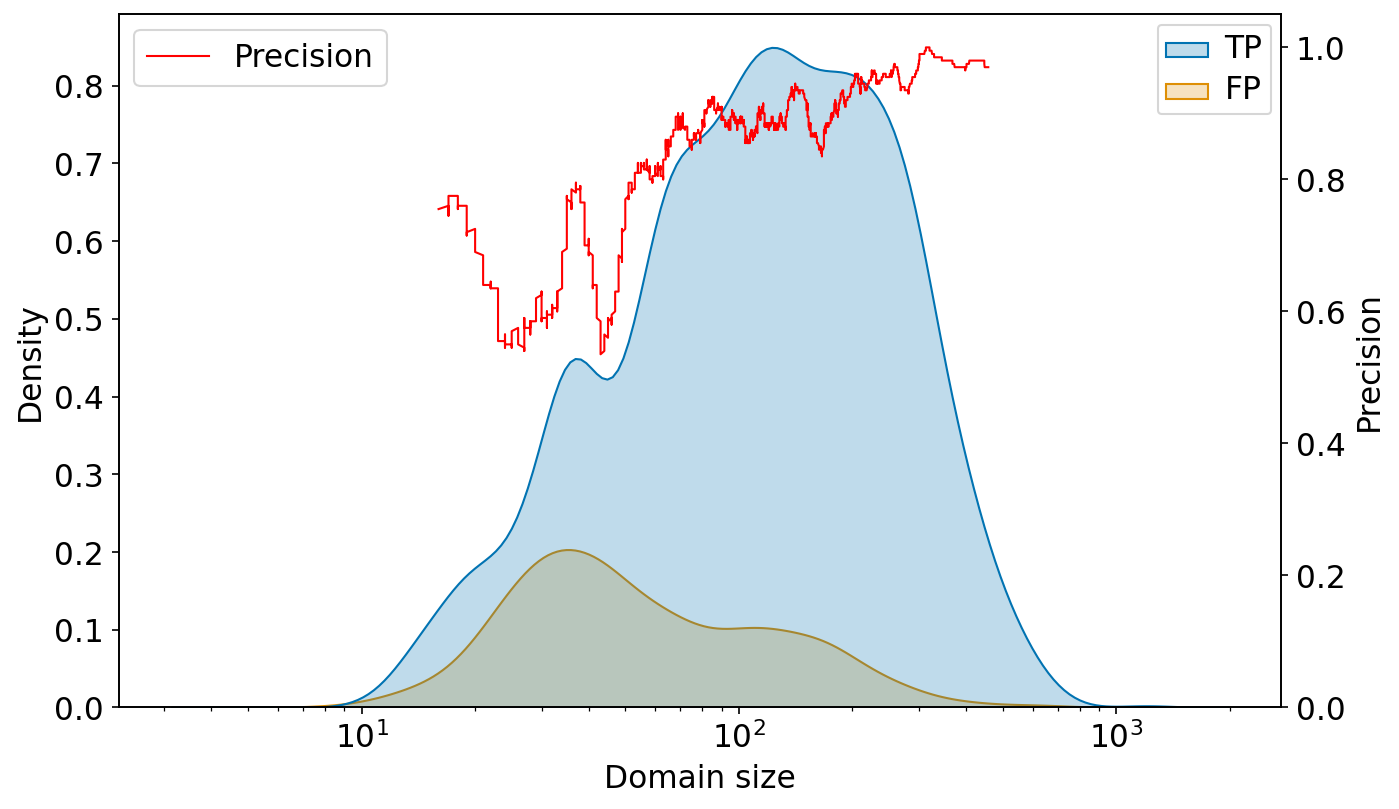

In [102]:
PlotDistributionOfLablesForAColumns(HMMER_preds_vsPFn_qadj, "qlen", "Domain size", log_scale=10)

In [103]:
correlation, p_value = spearmanr(pfn["size"], pfn["meanlddt"])
print(correlation)
print(p_value)

0.07893141506005232
1.1587525976796071e-14


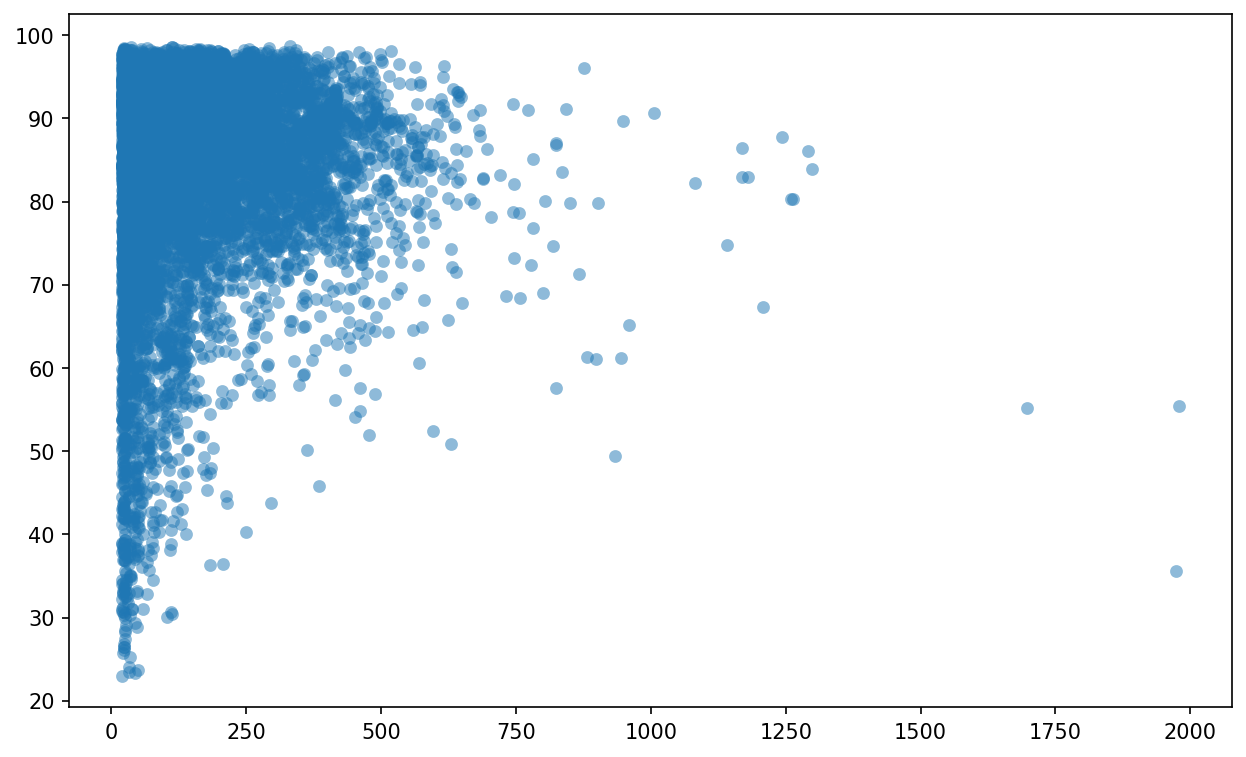

In [104]:
plt.figure(figsize=(10, 6), dpi=150)
plt.scatter(pfn["size"], pfn["meanlddt"], linewidths=0.1, alpha=0.5)